In [1]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import warnings

# ---------------------------
# 1. Load column names
# ---------------------------
def load_column_names(path):
    names = []
    with open(path, "r") as f:
        for line in f:
            if line.startswith("Column"):
                col_name = line.split(" ", 2)[-1].split(";")[0].strip()
                names.append(col_name)
    return names

# ---------------------------
# 2. Parse label legend
# ---------------------------
def parse_label_legend(path):
    legend = {}
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("Unique"):
                continue
            parts = re.split(r"\s*-\s*", line)
            if len(parts) == 3:
                idx, track, label = parts
                idx = int(idx.strip())
                track = track.strip()
                label = label.strip()
                if track not in legend:
                    legend[track] = {}
                legend[track][idx] = label
    return legend

# ---------------------------
# 3. Load .dat file
# ---------------------------
def load_dat_file(file_path, col_names):
    df = pd.read_csv(file_path, delimiter=" ", header=None)
    df.columns = col_names[:df.shape[1]]
    return df

# ---------------------------
# 4. Split columns by modality
# ---------------------------
def split_modalities(df):
    modalities = {}
    acc_cols = [c for c in df.columns if "Accelerometer" in c]
    imu_cols = [c for c in df.columns if "InertialMeasurementUnit" in c]
    loc_cols = [c for c in df.columns if "LOCATION" in c]
    reed_cols = [c for c in df.columns if "REED SWITCH" in c]

    if acc_cols: modalities['accelerometers'] = df[acc_cols].values
    if imu_cols: modalities['IMU'] = df[imu_cols].values
    if loc_cols: modalities['locations'] = df[loc_cols].values
    if reed_cols: modalities['reed_switches'] = df[reed_cols].values

    return modalities

# ---------------------------
# 5. Sliding windows (multi-modal)
# ---------------------------
def create_windows_multimodal(modalities_dict, labels_dict, window_size=100, stride=50):
    X_modalities = {mod: [] for mod in modalities_dict.keys()}
    y = []
    n_samples = len(next(iter(modalities_dict.values())))
    label_keys = list(labels_dict.keys())
    
    for start in range(0, n_samples - window_size + 1, stride):
        end = start + window_size
        for mod, data in modalities_dict.items():
            X_modalities[mod].append(data[start:end])
        # Assign label at window end
        y.append([labels_dict[k][end-1] for k in label_keys])

    X_modalities = {mod: np.array(arr) for mod, arr in X_modalities.items()}
    y = np.array(y)
    return X_modalities, y

# ---------------------------
# 6. Decode numeric labels (robust)
# ---------------------------
def decode_labels_numeric(y_array, legend, label_keys):
    decoded = []
    for row in y_array:
        row_dict = {}
        for key, val in zip(label_keys, row):
            track_dict = legend.get(key)
            if isinstance(track_dict, dict):
                row_dict[key] = track_dict.get(int(val), "Unknown")
            else:
                row_dict[key] = "Unknown"
        decoded.append(row_dict)
    return decoded

# ---------------------------
# 7. Filter rare classes
# ---------------------------
def filter_rare_classes(y_array, label_tracks, min_samples=10):
    """
    Filter out classes that have fewer than min_samples
    """
    y_filtered = y_array.copy()
    
    for i, task in enumerate(label_tracks):
        counts = Counter(y_array[:, i])
        rare_classes = [cls for cls, count in counts.items() if count < min_samples]
        
        if rare_classes:
            print(f"Filtering rare classes in {task}: {rare_classes}")
            # Replace rare classes with 0 (Unknown/Other)
            mask = np.isin(y_filtered[:, i], rare_classes)
            y_filtered[mask, i] = 0
    
    return y_filtered

# ---------------------------
# 8. Improved stratified split for multi-label
# ---------------------------
def stratified_multilabel_split(X_dict, y_array, test_size=0.3, random_state=42):
    """
    Create a more balanced split for multi-label data by considering
    the most important/balanced label for stratification
    """
    n_samples = y_array.shape[0]
    
    # Find the label column with best balance for stratification
    best_col = 0
    best_entropy = 0
    
    for i in range(y_array.shape[1]):
        counts = Counter(y_array[:, i])
        # Calculate normalized entropy as a measure of balance
        total = sum(counts.values())
        probs = [count/total for count in counts.values()]
        entropy = -sum(p * np.log2(p + 1e-10) for p in probs)
        normalized_entropy = entropy / np.log2(len(counts))
        
        if normalized_entropy > best_entropy:
            best_entropy = normalized_entropy
            best_col = i
    
    print(f"Using column {best_col} for stratification (entropy: {best_entropy:.3f})")
    
    # Create stratified split
    indices = np.arange(n_samples)
    try:
        train_idx, test_idx = train_test_split(
            indices, 
            test_size=test_size, 
            random_state=random_state,
            stratify=y_array[:, best_col]
        )
    except ValueError as e:
        print(f"Stratification failed: {e}")
        print("Falling back to random split...")
        train_idx, test_idx = train_test_split(
            indices, 
            test_size=test_size, 
            random_state=random_state
        )
    
    # Split the data
    X_train = {mod: X_dict[mod][train_idx] for mod in X_dict}
    X_test = {mod: X_dict[mod][test_idx] for mod in X_dict}
    y_train = y_array[train_idx]
    y_test = y_array[test_idx]
    
    return X_train, X_test, y_train, y_test

# ---------------------------
# 9. Check class distribution balance
# ---------------------------
def check_class_balance(y_train, y_test, label_tracks):
    """
    Check if classes are reasonably balanced between train and test sets
    """
    print("\n=== Class Distribution Check ===")
    
    for i, task in enumerate(label_tracks):
        train_counts = Counter(y_train[:, i])
        test_counts = Counter(y_test[:, i])
        
        all_classes = set(train_counts.keys()) | set(test_counts.keys())
        train_only = set(train_counts.keys()) - set(test_counts.keys())
        test_only = set(test_counts.keys()) - set(train_counts.keys())
        
        print(f"\n--- {task} ---")
        print(f"Total unique classes: {len(all_classes)}")
        print(f"Classes only in train: {len(train_only)} {list(train_only) if train_only else ''}")
        print(f"Classes only in test: {len(test_only)} {list(test_only) if test_only else ''}")
        
        # Show distribution for common classes
        common_classes = set(train_counts.keys()) & set(test_counts.keys())
        print(f"Classes in both: {len(common_classes)}")

# ---------------------------
# 10. Full preprocessing with improved splitting
# ---------------------------
def preprocess_opportunity_multimodal_balanced(dataset_folder,
                                               target_labels=None,
                                               window_size=100,
                                               stride=50,
                                               test_size=0.3,
                                               random_state=42,
                                               min_samples_per_class=10,
                                               filter_rare=True):
    if target_labels is None:
        target_labels = [
            "Locomotion", "HL_Activity", "LL_Left_Arm",
            "LL_Left_Arm_Object", "LL_Right_Arm",
            "LL_Right_Arm_Object", "ML_Both_Arms"
        ]

    col_names = load_column_names(os.path.join(dataset_folder, "column_names.txt"))
    legend = parse_label_legend(os.path.join(dataset_folder, "label_legend.txt"))

    X_mod_windows = {mod: [] for mod in ['accelerometers','IMU','locations','reed_switches']}
    y_windows = []

    files = [f for f in os.listdir(dataset_folder) if f.endswith(".dat")]
    
    for fname in files:
        df = load_dat_file(os.path.join(dataset_folder, fname), col_names)
        modalities = split_modalities(df)
        labels_dict = {track: df[track].values for track in target_labels}

        # Replace NaNs/Infs and scale
        for mod, arr in modalities.items():
            arr = np.nan_to_num(arr)
            modalities[mod] = StandardScaler().fit_transform(arr)

        # Sliding windows
        X_w, y_w = create_windows_multimodal(modalities, labels_dict, window_size, stride)
        for mod in X_w:
            X_mod_windows[mod].append(X_w[mod])
        y_windows.append(y_w)

    # Concatenate windows per modality
    X_mod_windows = {mod: np.concatenate(arr_list, axis=0) 
                     for mod, arr_list in X_mod_windows.items() if arr_list}
    y_windows = np.concatenate(y_windows, axis=0)

    print(f"Original data shape: {y_windows.shape}")
    
    # Filter rare classes if requested
    if filter_rare:
        y_windows = filter_rare_classes(y_windows, target_labels, min_samples_per_class)

    # Improved train/test split
    X_train_mod, X_test_mod, y_train, y_test = stratified_multilabel_split(
        X_mod_windows, y_windows, test_size, random_state
    )

    # Check class balance
    check_class_balance(y_train, y_test, target_labels)

    # Decode a few labels for verification
    decoded_example = decode_labels_numeric(y_train[:5], legend, target_labels)
    print(f"\nDecoded labels (sample): {decoded_example}")

    return (X_train_mod, y_train), (X_test_mod, y_test), legend, target_labels

# ---------------------------
# 11. Utility function to get balanced label distributions
# ---------------------------
def get_label_distributions_comparison(y_train, y_test, label_tracks):
    """
    Compare label distributions between train and test sets
    """
    print("\n=== Label Distribution Comparison ===")
    
    for i, task in enumerate(label_tracks):
        print(f"\n--- {task} ---")
        
        train_counts = Counter(y_train[:, i])
        test_counts = Counter(y_test[:, i])
        
        all_classes = sorted(set(train_counts.keys()) | set(test_counts.keys()))
        
        print(f"{'Class':<8} {'Train Count':<12} {'Train %':<10} {'Test Count':<11} {'Test %':<10}")
        print("-" * 60)
        
        train_total = len(y_train)
        test_total = len(y_test)
        
        for cls in all_classes:
            train_count = train_counts.get(cls, 0)
            test_count = test_counts.get(cls, 0)
            train_pct = (train_count / train_total) * 100
            test_pct = (test_count / test_total) * 100
            
            print(f"{cls:<8} {train_count:<12} {train_pct:<10.2f} {test_count:<11} {test_pct:<10.2f}")

# ---------------------------
# Example usage
# ---------------------------
# Usage example for your main code
if __name__ == "__main__":
    dataset_folder = "/kaggle/input/opportunity-activity-recognition/OpportunityUCIDataset/dataset"
    (train_X_mod, train_y), (test_X_mod, test_y), legend, label_tracks = preprocess_opportunity_multimodal_balanced(
        dataset_folder=dataset_folder,
        window_size=100,
        stride=50,
        test_size=0.3,
        min_samples_per_class=100,
        filter_rare=True
    )
    
    # Summary
    print(f"\nLabel tracks: {label_tracks}")
    for mod in train_X_mod:
        print(f"Train {mod}: {train_X_mod[mod].shape}")
    print(f"Train labels: {train_y.shape}")
    print(f"Test labels: {test_y.shape}")
    
    # Show detailed comparison
    get_label_distributions_comparison(train_y, test_y, label_tracks)

Original data shape: (17350, 7)
Filtering rare classes in LL_Left_Arm: [201, 203, 209, 208, 207, 210]
Filtering rare classes in LL_Left_Arm_Object: [319, 311, 308, 316, 307, 306, 310, 312, 322, 309, 323, 315, 317]
Filtering rare classes in LL_Right_Arm: [401, 403, 402, 409]
Filtering rare classes in LL_Right_Arm_Object: [515, 523]
Using column 1 for stratification (entropy: 0.890)

=== Class Distribution Check ===

--- Locomotion ---
Total unique classes: 5
Classes only in train: 0 
Classes only in test: 0 
Classes in both: 5

--- HL_Activity ---
Total unique classes: 6
Classes only in train: 0 
Classes only in test: 0 
Classes in both: 6

--- LL_Left_Arm ---
Total unique classes: 6
Classes only in train: 0 
Classes only in test: 0 
Classes in both: 6

--- LL_Left_Arm_Object ---
Total unique classes: 11
Classes only in train: 0 
Classes only in test: 0 
Classes in both: 11

--- LL_Right_Arm ---
Total unique classes: 10
Classes only in train: 0 
Classes only in test: 0 
Classes in both:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import psutil
import time
from typing import Dict, List, Optional
from dataclasses import dataclass
from abc import ABC, abstractmethod

# ---------------------------
# Resource Monitor
# ---------------------------
@dataclass
class ResourceMetrics:
    cpu_percent: float
    memory_percent: float
    inference_latency: float
    power_level: float  # 0.0-1.0 (estimated battery level for mobile devices)
    temperature: Optional[float] = None

class ResourceMonitor:
    def __init__(self, history_size=10):
        self.history_size = history_size
        self.latency_history = []
        self.cpu_history = []
        self.memory_history = []
    
    def get_current_metrics(self) -> ResourceMetrics:
        cpu_percent = psutil.cpu_percent(interval=0.1)
        memory = psutil.virtual_memory()
        
        # Estimate power level (in real IoT device, this would come from battery API)
        power_level = max(0.1, 1.0 - (cpu_percent / 100.0) * 0.5)
        
        # Calculate average latency from history
        avg_latency = sum(self.latency_history[-5:]) / max(1, len(self.latency_history[-5:]))
        
        return ResourceMetrics(
            cpu_percent=cpu_percent,
            memory_percent=memory.percent,
            inference_latency=avg_latency,
            power_level=power_level
        )
    
    def update_latency(self, latency: float):
        self.latency_history.append(latency)
        if len(self.latency_history) > self.history_size:
            self.latency_history.pop(0)

# ---------------------------
# Adaptive Sparsity Controller
# ---------------------------
class SparsityController:
    def __init__(self, min_sparsity=0.3, max_sparsity=0.95, target_latency_ms=100):
        self.min_sparsity = min_sparsity
        self.max_sparsity = max_sparsity
        self.target_latency_ms = target_latency_ms
        self.current_sparsity = 0.8
        self.adaptation_rate = 0.1
        
    def calculate_target_sparsity(self, metrics: ResourceMetrics) -> float:
        """Calculate target sparsity based on current resource constraints"""
        
        # Base sparsity adjustment factors
        cpu_factor = min(1.0, metrics.cpu_percent / 80.0)  # High CPU usage increases sparsity
        memory_factor = min(1.0, metrics.memory_percent / 85.0)  # High memory usage increases sparsity
        latency_factor = max(0.5, metrics.inference_latency / self.target_latency_ms)  # High latency increases sparsity
        power_factor = 1.0 - metrics.power_level  # Low power increases sparsity
        
        # Weighted combination
        resource_pressure = (
            0.3 * cpu_factor + 
            0.2 * memory_factor + 
            0.3 * latency_factor + 
            0.2 * power_factor
        )
        
        # Map to sparsity range
        target_sparsity = self.min_sparsity + (self.max_sparsity - self.min_sparsity) * resource_pressure
        
        # Smooth adaptation
        self.current_sparsity += self.adaptation_rate * (target_sparsity - self.current_sparsity)
        self.current_sparsity = max(self.min_sparsity, min(self.max_sparsity, self.current_sparsity))
        
        return self.current_sparsity

# ---------------------------
# Dynamic Sparse Linear Layer
# ---------------------------
class DynamicSparseLinear(nn.Module):
    def __init__(self, in_features, out_features, initial_sparsity=0.8):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        
        # Store weight importance scores for smart pruning
        self.register_buffer("weight_importance", torch.ones_like(self.weight))
        self.register_buffer("mask", torch.ones_like(self.weight))
        self.current_sparsity = initial_sparsity
        
        self._update_mask(initial_sparsity)
    
    def _update_mask(self, target_sparsity):
        """Update mask based on weight importance and target sparsity"""
        if target_sparsity == self.current_sparsity:
            return
            
        # Calculate importance scores (magnitude-based pruning)
        importance = torch.abs(self.weight.data) * self.weight_importance
        
        # Determine threshold for pruning
        flat_importance = importance.flatten()
        threshold_idx = int(target_sparsity * len(flat_importance))
        threshold = torch.sort(flat_importance)[0][threshold_idx] if threshold_idx < len(flat_importance) else 0
        
        # Update mask
        self.mask = (importance > threshold).float()
        self.current_sparsity = 1.0 - self.mask.mean().item()
    
    def update_sparsity(self, target_sparsity):
        """Public method to update sparsity"""
        self._update_mask(target_sparsity)
    
    def update_importance(self, gradients=None):
        """Update weight importance based on gradients or other metrics"""
        if gradients is not None:
            # Exponential moving average of gradient magnitude
            alpha = 0.9
            grad_importance = torch.abs(gradients)
            self.weight_importance = alpha * self.weight_importance + (1 - alpha) * grad_importance
    
    def forward(self, x):
        # Apply mask to weights during forward pass
        masked_weight = self.weight * self.mask
        return F.linear(x, masked_weight, self.bias)
    
    def get_flops(self):
        """Calculate effective FLOPs considering sparsity"""
        active_weights = self.mask.sum().item()
        return active_weights  # Simplified FLOP count

# ---------------------------
# Adaptive Modality Encoder
# ---------------------------
class AdaptiveModalityEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=32, use_conv=True, initial_sparsity=0.7):
        super().__init__()
        self.use_conv = use_conv
        self.current_sparsity = initial_sparsity
        
        if use_conv:
            self.conv = nn.Sequential(
                nn.Conv1d(input_dim, hidden_dim, 3, padding=1),
                nn.ReLU(),
                nn.Conv1d(hidden_dim, hidden_dim, 3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(1)
            )
            fc_in = hidden_dim
        else:
            fc_in = input_dim

        self.fc = nn.Sequential(
            DynamicSparseLinear(fc_in, output_dim, initial_sparsity),
            nn.ReLU(),
            DynamicSparseLinear(output_dim, output_dim, initial_sparsity*0.5),
            nn.LayerNorm(output_dim)
        )
    
    def update_sparsity(self, target_sparsity):
        """Update sparsity for all sparse layers"""
        self.current_sparsity = target_sparsity
        for layer in self.fc:
            if isinstance(layer, DynamicSparseLinear):
                layer.update_sparsity(target_sparsity)
    
    def forward(self, x):
        if self.use_conv:
            x = x.transpose(1, 2)  # (batch, features, seq_len)
            x = self.conv(x).squeeze(-1)
        else:
            x = x.mean(dim=1)
        return self.fc(x)

# ---------------------------
# Adaptive Cross-Modal Attention
# ---------------------------
class AdaptiveCrossModalAttention(nn.Module):
    def __init__(self, feature_dim, num_heads=4, initial_sparsity=0.6):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = feature_dim // num_heads
        self.scale = math.sqrt(self.head_dim)
        self.current_sparsity = initial_sparsity

        self.q_proj = DynamicSparseLinear(feature_dim, feature_dim, initial_sparsity)
        self.k_proj = DynamicSparseLinear(feature_dim, feature_dim, initial_sparsity)
        self.v_proj = DynamicSparseLinear(feature_dim, feature_dim, initial_sparsity)
        self.out_proj = DynamicSparseLinear(feature_dim, feature_dim, initial_sparsity)
        
        # Attention head importance for dynamic head pruning
        self.register_buffer("head_importance", torch.ones(num_heads))
        self.active_heads = num_heads
    
    def update_sparsity(self, target_sparsity):
        """Update sparsity and potentially reduce number of attention heads"""
        self.current_sparsity = target_sparsity
        
        # Update linear layer sparsity
        for layer in [self.q_proj, self.k_proj, self.v_proj, self.out_proj]:
            layer.update_sparsity(target_sparsity)
        
        # Adaptive head pruning for extreme resource constraints
        if target_sparsity > 0.85:
            self.active_heads = max(1, self.num_heads // 2)
        elif target_sparsity > 0.7:
            self.active_heads = max(2, int(self.num_heads * 0.75))
        else:
            self.active_heads = self.num_heads

    def forward(self, modalities: List[torch.Tensor]):
        x = torch.stack(modalities, dim=1)  # (batch, n_mod, features)
        b, n_mod, f = x.shape

        Q = self.q_proj(x).view(b, n_mod, self.num_heads, self.head_dim).transpose(1,2)
        K = self.k_proj(x).view(b, n_mod, self.num_heads, self.head_dim).transpose(1,2)
        V = self.v_proj(x).view(b, n_mod, self.num_heads, self.head_dim).transpose(1,2)
        
        # Use only active heads
        Q = Q[:, :self.active_heads]
        K = K[:, :self.active_heads]
        V = V[:, :self.active_heads]

        attn = torch.matmul(Q, K.transpose(-2,-1)) / self.scale
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, V).transpose(1,2).contiguous().view(b, n_mod, -1)
        
        # Adjust output dimension if using fewer heads
        if self.active_heads < self.num_heads:
            out = F.linear(out, torch.eye(f, out.size(-1)).to(out.device))
        
        out = self.out_proj(out).mean(dim=1)
        return out

# ---------------------------
# Adaptive Multi-label Classifier
# ---------------------------
class AdaptiveMultiLabelClassifier(nn.Module):
    def __init__(self, input_dim, task_configs: Dict[str,int], hidden_dim=32, initial_sparsity=0.7):
        super().__init__()
        self.task_configs = task_configs
        self.current_sparsity = initial_sparsity
        
        self.shared = nn.Sequential(
            DynamicSparseLinear(input_dim, hidden_dim, initial_sparsity),
            nn.ReLU(),
            DynamicSparseLinear(hidden_dim, hidden_dim, initial_sparsity*0.5),
            nn.ReLU()
        )
        
        self.heads = nn.ModuleDict({
            task: DynamicSparseLinear(hidden_dim, n_classes, initial_sparsity*0.3)
            for task, n_classes in task_configs.items()
        })
        
        # Task importance for dynamic task selection
        self.register_buffer("task_importance", torch.ones(len(task_configs)))
        self.active_tasks = list(task_configs.keys())
    
    def update_sparsity(self, target_sparsity):
        """Update sparsity and potentially disable low-priority tasks"""
        self.current_sparsity = target_sparsity
        
        # Update shared layers
        for layer in self.shared:
            if isinstance(layer, DynamicSparseLinear):
                layer.update_sparsity(target_sparsity)
        
        # Update task heads
        for head in self.heads.values():
            head.update_sparsity(target_sparsity * 0.5)  # Task heads can be sparser
        
        # Disable tasks under extreme resource pressure
        if target_sparsity > 0.9:
            # Keep only the most important task
            most_important_task = max(self.task_configs.keys(), 
                                    key=lambda t: self.task_importance[list(self.task_configs.keys()).index(t)])
            self.active_tasks = [most_important_task]
        else:
            self.active_tasks = list(self.task_configs.keys())

    def forward(self, x):
        x = self.shared(x)
        # Only compute outputs for active tasks
        return {task: self.heads[task](x) for task in self.active_tasks}

# ---------------------------
# Adaptive LightSpaN
# ---------------------------
class AdaptiveLightSpaN(nn.Module):
    def __init__(self, modality_configs: Dict[str,int], task_configs: Dict[str,int],
                 encoder_hidden=32, encoder_output=16, classifier_hidden=32, 
                 initial_sparsity=0.8, target_latency_ms=100):
        super().__init__()
        
        # Resource management
        self.resource_monitor = ResourceMonitor()
        self.sparsity_controller = SparsityController(
            min_sparsity=0.3, max_sparsity=0.95, target_latency_ms=target_latency_ms
        )
        
        # Model components
        self.encoders = nn.ModuleDict({
            mod: AdaptiveModalityEncoder(dim, encoder_hidden, encoder_output,
                                       use_conv=(dim>16), initial_sparsity=initial_sparsity)
            for mod, dim in modality_configs.items()
        })
        
        self.fusion = AdaptiveCrossModalAttention(encoder_output, num_heads=4, 
                                                initial_sparsity=initial_sparsity*0.8)
        
        self.classifier = AdaptiveMultiLabelClassifier(encoder_output, task_configs, 
                                                     classifier_hidden, initial_sparsity)
        
        self.norm = nn.BatchNorm1d(encoder_output)
        
        # Adaptation tracking
        self.adaptation_counter = 0
        self.adapt_every_n_inferences = 10  # Adapt sparsity every N inferences
    
    def adapt_sparsity(self):
        """Adapt model sparsity based on current resource constraints"""
        metrics = self.resource_monitor.get_current_metrics()
        target_sparsity = self.sparsity_controller.calculate_target_sparsity(metrics)
        
        # Update all components
        for encoder in self.encoders.values():
            encoder.update_sparsity(target_sparsity)
        
        self.fusion.update_sparsity(target_sparsity * 0.8)
        self.classifier.update_sparsity(target_sparsity)
        
        return target_sparsity, metrics
    
    def forward(self, modality_data: Dict[str, torch.Tensor]):
        start_time = time.time()
        
        # Encode modalities
        feats = []
        for mod_name, data in modality_data.items():
            if mod_name in self.encoders:  # Skip disabled modalities
                feats.append(self.encoders[mod_name](data))
        
        if not feats:  # Fallback if all modalities disabled
            batch_size = next(iter(modality_data.values())).size(0)
            feats = [torch.zeros(batch_size, 16).to(next(self.parameters()).device)]
        
        # Fusion and classification
        fused = self.fusion(feats) if len(feats) > 1 else feats[0]
        fused = self.norm(fused)
        outputs = self.classifier(fused)
        
        # Update latency tracking
        inference_time = (time.time() - start_time) * 1000  # Convert to ms
        self.resource_monitor.update_latency(inference_time)
        
        # Periodic adaptation
        self.adaptation_counter += 1
        if self.adaptation_counter >= self.adapt_every_n_inferences:
            target_sparsity, metrics = self.adapt_sparsity()
            self.adaptation_counter = 0
            
            # Optional: log adaptation info
            if hasattr(self, '_debug') and self._debug:
                print(f"Adapted sparsity to {target_sparsity:.3f}, "
                      f"CPU: {metrics.cpu_percent:.1f}%, "
                      f"Latency: {metrics.inference_latency:.1f}ms")
        
        return outputs
    def resize_output_layers(self, new_task_configs: Dict[str, int]):
        """Dynamically resize classification heads to accommodate new classes"""
        print(f"Resizing output layers from {self.classifier.task_configs} to {new_task_configs}")
        
        for task_name, new_num_classes in new_task_configs.items():
            if task_name in self.classifier.task_configs:
                current_num_classes = self.classifier.task_configs[task_name]
                
                if new_num_classes > current_num_classes:
                    # Need to expand the classification head
                    old_head = self.classifier.heads[task_name]
                    hidden_dim = old_head.weight.shape[1]  # Input dimension
                    current_sparsity = old_head.current_sparsity
                    
                    # Create new larger head
                    new_head = DynamicSparseLinear(hidden_dim, new_num_classes, current_sparsity)
                    
                    # Copy weights from old head to new head (for existing classes)
                    with torch.no_grad():
                        new_head.weight.data[:current_num_classes] = old_head.weight.data
                        new_head.bias.data[:current_num_classes] = old_head.bias.data
                        
                        # Copy importance scores and mask
                        new_head.weight_importance[:current_num_classes] = old_head.weight_importance
                        new_head.mask[:current_num_classes] = old_head.mask
                        
                        # Initialize new classes with small random values
                        new_head.weight.data[current_num_classes:] *= 0.1
                        new_head.weight_importance[current_num_classes:] = torch.abs(new_head.weight.data[current_num_classes:])
                        new_head.mask[current_num_classes:] = (new_head.weight_importance[current_num_classes:] > 
                                                             new_head.weight_importance.flatten().median()).float()
                    
                    # Replace the old head
                    self.classifier.heads[task_name] = new_head
                    print(f"  Expanded {task_name} from {current_num_classes} to {new_num_classes} classes")
                
                elif new_num_classes < current_num_classes:
                    print(f"  Warning: Shrinking {task_name} from {current_num_classes} to {new_num_classes} classes (weights will be truncated)")
            else:
                # New task - create head from scratch
                hidden_dim = list(self.classifier.heads.values())[0].weight.shape[1]  # Get hidden dim from existing head
                current_sparsity = self.classifier.current_sparsity
                self.classifier.heads[task_name] = DynamicSparseLinear(hidden_dim, new_num_classes, current_sparsity)
                print(f"  Added new task {task_name} with {new_num_classes} classes")
        
        # Update task configs and importance buffer
        self.classifier.task_configs = new_task_configs.copy()
        self.classifier.register_buffer("task_importance", torch.ones(len(new_task_configs)))
        self.classifier.active_tasks = list(new_task_configs.keys())
        
        print(f"Output layer resizing complete. New task configs: {new_task_configs}")

    def auto_detect_and_resize_classes(self, train_labels: Dict[str, torch.Tensor], use_class_count=True):
        """Automatically detect the number of classes from training data and resize accordingly
        
        Args:
            train_labels: Dict mapping task names to label tensors
            use_class_count: If True, use actual number of unique classes. 
                           If False, use max_class_id + 1 (for sequential class IDs)
        """
        detected_classes = {}
        
        for task_name, labels in train_labels.items():
            unique_classes = torch.unique(labels[labels >= 0])  # Exclude negative values (missing labels)
            max_class = int(unique_classes.max().item())
            
            if use_class_count:
                # Use actual number of unique classes (recommended for sparse class IDs)
                num_classes = len(unique_classes)
                print(f"Task '{task_name}': detected {len(unique_classes)} unique classes, max class ID: {max_class}")
                print(f"  Using {num_classes} output neurons for {len(unique_classes)} classes")
            else:
                # Use max class ID + 1 (only for sequential 0,1,2,3... class IDs)
                num_classes = max_class + 1
                print(f"Task '{task_name}': detected {len(unique_classes)} unique classes, max class ID: {max_class}")
                print(f"  Using {num_classes} output neurons (max_class_id + 1)")
            
            detected_classes[task_name] = num_classes
            print(f"  Unique classes: {unique_classes.tolist()}")
        
        # Store class mappings for later use in training/inference
        self.class_mappings = {}
        for task_name, labels in train_labels.items():
            unique_classes = torch.unique(labels[labels >= 0])
            # Create mapping from class_id to output_index
            self.class_mappings[task_name] = {
                int(class_id.item()): idx for idx, class_id in enumerate(unique_classes)
            }
        
        print(f"\nClass mappings created:")
        for task_name, mapping in self.class_mappings.items():
            print(f"  {task_name}: {mapping}")
        
        # Resize if needed
        if detected_classes != self.classifier.task_configs:
            self.resize_output_layers(detected_classes)
        
        return detected_classes

    def map_labels_to_indices(self, labels: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Convert class IDs to output indices for training/inference
        
        Args:
            labels: Dict mapping task names to label tensors with original class IDs
            
        Returns:
            Dict mapping task names to label tensors with mapped indices (0 to num_classes-1)
        """
        if not hasattr(self, 'class_mappings'):
            raise ValueError("Class mappings not found. Run auto_detect_and_resize_classes() first.")
        
        mapped_labels = {}
        for task_name, task_labels in labels.items():
            if task_name not in self.class_mappings:
                print(f"Warning: No class mapping found for task '{task_name}', keeping original labels")
                mapped_labels[task_name] = task_labels
                continue
            
            mapping = self.class_mappings[task_name]
            mapped_task_labels = task_labels.clone()
            
            # Map each class ID to its corresponding output index
            for original_id, new_index in mapping.items():
                mask = (task_labels == original_id)
                mapped_task_labels[mask] = new_index
            
            mapped_labels[task_name] = mapped_task_labels
        
        return mapped_labels
    
    def map_predictions_to_class_ids(self, predictions: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Convert prediction indices back to original class IDs
        
        Args:
            predictions: Dict mapping task names to prediction tensors (with indices 0 to num_classes-1)
            
        Returns:
            Dict mapping task names to prediction tensors with original class IDs
        """
        if not hasattr(self, 'class_mappings'):
            print("Warning: No class mappings found, returning original predictions")
            return predictions
        
        mapped_predictions = {}
        for task_name, task_preds in predictions.items():
            if task_name not in self.class_mappings:
                mapped_predictions[task_name] = task_preds
                continue
            
            mapping = self.class_mappings[task_name]
            # Create reverse mapping (index -> original_class_id)
            reverse_mapping = {idx: original_id for original_id, idx in mapping.items()}
            
            mapped_task_preds = task_preds.clone()
            for index, original_id in reverse_mapping.items():
                mask = (task_preds == index)
                mapped_task_preds[mask] = original_id
            
            mapped_predictions[task_name] = mapped_task_preds
        
        return mapped_predictions

    def get_model_stats(self):
        """Get current model efficiency statistics"""
        total_params = sum(p.numel() for p in self.parameters())
        
        # Count active parameters in sparse layers
        active_params = 0
        total_flops = 0
        
        for module in self.modules():
            if isinstance(module, DynamicSparseLinear):
                active_params += module.mask.sum().item()
                total_flops += module.get_flops()
        
        effective_sparsity = 1.0 - (active_params / max(1, total_params))
        
        stats = {
            'total_params': total_params,
            'active_params': active_params,
            'effective_sparsity': effective_sparsity,
            'estimated_flops': total_flops,
            'active_tasks': len(self.classifier.active_tasks),
            'active_attention_heads': self.fusion.active_heads,
            'task_configs': self.classifier.task_configs.copy()
        }
        
        if hasattr(self, 'class_mappings'):
            stats['class_mappings'] = self.class_mappings.copy()
        
        return stats

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import psutil
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import time
from collections import deque, defaultdict

# ---------------------------
# Live Streaming Dataset Simulator
# ---------------------------
class LiveStreamingOpportunityDataset:
    def __init__(self, X_mod, y, label_tracks, window_size=100, batch_size=32, 
                 stream_rate=10, noise_factor=0.1, shuffle_data=True,
                 balance_buffer=True, adaptive_noise=True):
        """
        Improved IoT stream simulator with:
        - Label balancing in buffer
        - Adaptive noise injection
        - Dynamic window-based batching
        
        X_mod: dict of modality arrays (each shape: N x features)
        y: numpy array of labels
        """
        
        self.X_mod = X_mod
        self.y = y
        self.label_tracks = label_tracks
        self.window_size = window_size
        self.batch_size = batch_size
        self.stream_rate = stream_rate
        self.noise_factor = noise_factor
        self.adaptive_noise = adaptive_noise
        self.balance_buffer = balance_buffer

        self.n_samples = self.y.shape[0]

        # Shuffle data initially to avoid static ordering patterns
        if shuffle_data:
            idx = np.random.permutation(self.n_samples)
            self.X_mod = {mod: data[idx] for mod, data in self.X_mod.items()}
            self.y = self.y[idx]

        # Create buffer and tracking metrics
        self.streaming_buffer = deque(maxlen=window_size * 3)
        self.current_position = 0
        self.label_count = defaultdict(int)

    def _adaptive_noise_injection(self, batch_X):
        """Apply noise **only if class is well-learned** (based on heuristics)"""
        for mod in batch_X:
            if self.adaptive_noise and self.label_count:
                # Example heuristic: reduce noise for rare classes
                scaling = np.clip(min(self.label_count.values()) / (max(self.label_count.values()) + 1e-5), 0.3, 1.0)
                noise = torch.randn_like(batch_X[mod]) * self.noise_factor * scaling
            else:
                noise = torch.randn_like(batch_X[mod]) * self.noise_factor
            
            batch_X[mod] = batch_X[mod] + noise
        return batch_X

    def _add_to_buffer(self, X_tensor, y_tensor):
        """Add samples to buffer with optional label balancing"""
        for i in range(len(y_tensor)):
            label = y_tensor[i]  # shape [7]
            for task_index, task_label in enumerate(label):
                self.label_count[(task_index, int(task_label.item()))] += 1

            if self.balance_buffer:
                # Prioritize under-represented classes
                if self.label_count[label] < max(self.label_count.values(), default=0) * 0.7 or len(self.streaming_buffer) < 10:
                    self.streaming_buffer.append(({mod: X_tensor[mod][i] for mod in X_tensor}, y_tensor[i]))
                    self.label_count[label] += 1
            else:
                self.streaming_buffer.append(({mod: X_tensor[mod][i] for mod in X_tensor}, y_tensor[i]))
                self.label_count[label] += 1

    def get_next_stream_batch(self):
        """Simulates receiving sensor data in real time"""
        if self.current_position >= self.n_samples:
            self.current_position = 0  # Loop for continuous streaming

        end = min(self.current_position + self.stream_rate, self.n_samples)

        # Extract and convert
        stream_X = {mod: torch.tensor(data[self.current_position:end], dtype=torch.float32) 
                   for mod, data in self.X_mod.items()}
        stream_y = torch.tensor(self.y[self.current_position:end], dtype=torch.long)

        # Add to buffer
        self._add_to_buffer(stream_X, stream_y)

        self.current_position = end
        return len(stream_y)

    def get_training_windows(self):
        """Generate sliding windows for online learning"""
        if len(self.streaming_buffer) < self.window_size:
            return []

        buffer_list = list(self.streaming_buffer)
        windows = []

        # Sliding window with 50% overlap
        for start_idx in range(0, len(buffer_list) - self.window_size + 1, self.window_size // 2):
            end_idx = start_idx + self.window_size
            window_samples = buffer_list[start_idx:end_idx]

            window_X, window_y = {}, []

            # Collect window samples
            for sample_X, sample_y in window_samples:
                for mod in sample_X:
                    if mod not in window_X:
                        window_X[mod] = []
                    window_X[mod].append(sample_X[mod])
                window_y.append(sample_y)

            window_X = {mod: torch.stack(data) for mod, data in window_X.items()}
            window_y = torch.stack(window_y)

            # Batch inside window
            for b_start in range(0, self.window_size, self.batch_size):
                b_end = min(b_start + self.batch_size, self.window_size)
                batch_X = {mod: data[b_start:b_end] for mod, data in window_X.items()}
                batch_y = window_y[b_start:b_end]

                batch_X = self._adaptive_noise_injection(batch_X)
                windows.append((batch_X, batch_y))

        return windows

# ---------------------------
# Enhanced Adaptive Learning Rate Scheduler for Streaming
# ---------------------------
class StreamingLRScheduler:
    def __init__(self, optimizer, factor=0.9, patience=200, min_lr=1e-6, warmup_steps=0, 
                 cosine_annealing=False, max_lr=None, cycle_length=1000):
        """
        Enhanced learning rate scheduler with multiple strategies
        
        Args:
            optimizer: PyTorch optimizer
            factor: Factor by which to reduce LR on plateau
            patience: Steps without improvement before reducing
            min_lr: Minimum learning rate
            warmup_steps: Number of warmup steps for gradual LR increase
            cosine_annealing: Whether to use cosine annealing
            max_lr: Maximum LR for cosine annealing (if None, uses initial LR)
            cycle_length: Length of cosine annealing cycle
        """
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.warmup_steps = warmup_steps
        self.cosine_annealing = cosine_annealing
        self.cycle_length = cycle_length
        
        # Store initial LR
        self.initial_lr = optimizer.param_groups[0]['lr']
        self.max_lr = max_lr if max_lr is not None else self.initial_lr
        
        # State tracking
        self.best_loss = float("inf")
        self.steps_since_improve = 0
        self.current_step = 0
        self.lr_history = []

    def step(self, current_loss):
        self.current_step += 1
        current_lr = self.optimizer.param_groups[0]['lr']
        
        # Warmup phase
        if self.current_step <= self.warmup_steps:
            warmup_lr = self.initial_lr * (self.current_step / self.warmup_steps)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = warmup_lr
            self.lr_history.append(warmup_lr)
            return
        
        # Cosine annealing
        if self.cosine_annealing:
            effective_step = (self.current_step - self.warmup_steps) % self.cycle_length
            cosine_lr = self.min_lr + (self.max_lr - self.min_lr) * \
                       0.5 * (1 + np.cos(np.pi * effective_step / self.cycle_length))
            cosine_lr = max(cosine_lr, self.min_lr)
            
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = cosine_lr
            self.lr_history.append(cosine_lr)
        else:
            # Plateau-based reduction
            if current_loss < self.best_loss:
                self.best_loss = current_loss
                self.steps_since_improve = 0
            else:
                self.steps_since_improve += 1

            if self.steps_since_improve >= self.patience:
                for param_group in self.optimizer.param_groups:
                    new_lr = max(param_group["lr"] * self.factor, self.min_lr)
                    param_group["lr"] = new_lr
                self.steps_since_improve = 0
                print(f"🔽 Reduced learning rate to {new_lr:.2e}")
            
            self.lr_history.append(current_lr)
    
    def get_lr_history(self):
        """Get history of learning rate changes"""
        return self.lr_history

# ---------------------------
# Enhanced Model Statistics Printing Functions
# ---------------------------
def print_model_architecture_metrics(model, detailed=True):
    """Print comprehensive model architecture and efficiency metrics"""
    print("\n" + "="*70)
    print("🏗️  ADAPTIVE MODEL ARCHITECTURE METRICS")
    print("="*70)
    
    # Get built-in model statistics
    stats = model.get_model_stats()
    
    # Basic model statistics
    print(f"📊 Model Parameters:")
    print(f"   • Total Parameters: {stats['total_params']:,}")
    print(f"   • Active Parameters: {stats['active_params']:,}")
    print(f"   • Effective Sparsity: {stats['effective_sparsity']:.3f} ({stats['effective_sparsity']*100:.1f}%)")
    print(f"   • Estimated FLOPs: {stats['estimated_flops']:,}")
    
    print(f"\n🎯 Active Components:")
    print(f"   • Active Tasks: {stats['active_tasks']}")
    print(f"   • Active Attention Heads: {stats['active_attention_heads']}")
    
    if detailed:
        print(f"\n🔍 Detailed Component Analysis:")
        
        # Encoder sparsity breakdown
        print(f"   📡 Modality Encoders:")
        for mod_name, encoder in model.encoders.items():
            print(f"      └── {mod_name}: Sparsity = {encoder.current_sparsity:.3f}")
        
        # Fusion layer details
        print(f"   🔗 Cross-Modal Fusion:")
        print(f"      └── Attention Sparsity: {model.fusion.current_sparsity:.3f}")
        print(f"      └── Active Heads: {model.fusion.active_heads}/{model.fusion.num_heads}")
        
        # Classifier details
        print(f"   🎯 Multi-Label Classifier:")
        print(f"      └── Sparsity: {model.classifier.current_sparsity:.3f}")
        print(f"      └── Active Tasks: {len(model.classifier.active_tasks)}")
        for task in model.classifier.active_tasks:
            print(f"         • {task}")
        
        # Resource monitor info if available
        if hasattr(model, 'resource_monitor'):
            metrics = model.resource_monitor.get_current_metrics()
            print(f"\n📊 Current Resource Metrics:")
            print(f"   • CPU Usage: {metrics.cpu_percent:.1f}%")
            print(f"   • Memory Usage: {metrics.memory_percent:.1f}%")
            print(f"   • Inference Latency: {metrics.inference_latency:.1f}ms")
            print(f"   • Power Level: {metrics.power_level:.3f}")
        
        # Sparsity controller info
        if hasattr(model, 'sparsity_controller'):
            sc = model.sparsity_controller
            print(f"\n⚙️  Sparsity Controller:")
            print(f"   • Current Sparsity: {sc.current_sparsity:.3f}")
            print(f"   • Target Latency: {sc.target_latency_ms}ms")
            print(f"   • Sparsity Range: {sc.min_sparsity:.3f} - {sc.max_sparsity:.3f}")
    
    print("="*70)

def print_layer_wise_sparsity(model):
    """Print sparsity information for each layer"""
    print("\n" + "="*50)
    print("🔍 LAYER-WISE SPARSITY ANALYSIS")
    print("="*50)
    
    total_sparse_params = 0
    total_params = 0
    
    for name, module in model.named_modules():
        # Check if module has sparsity capability (adapt based on your model structure)
        if hasattr(module, 'mask') and hasattr(module, 'weight'):
            active_params = module.mask.sum().item() if hasattr(module.mask, 'sum') else 0
            total_layer_params = module.mask.numel() if hasattr(module.mask, 'numel') else module.weight.numel()
            sparsity = 1.0 - (active_params / total_layer_params) if total_layer_params > 0 else 0
            
            total_sparse_params += active_params
            total_params += total_layer_params
            
            print(f"📍 {name}")
            print(f"   • Shape: {list(module.weight.shape)}")
            print(f"   • Active: {active_params:,}/{total_layer_params:,}")
            print(f"   • Sparsity: {sparsity:.3f} ({sparsity*100:.1f}%)")
            if hasattr(module, 'get_flops'):
                print(f"   • FLOPs: {module.get_flops():,}")
    
    if total_params > 0:
        overall_sparsity = 1.0 - (total_sparse_params / total_params)
        print(f"\n📊 Overall Sparse Layers:")
        print(f"   • Total Sparse Parameters: {total_sparse_params:,}/{total_params:,}")
        print(f"   • Overall Sparsity: {overall_sparsity:.3f} ({overall_sparsity*100:.1f}%)")
    
    print("="*50)

def track_adaptation_metrics(model, step, print_every=100):
    """Track and print adaptation metrics during training"""
    if step % print_every == 0:
        stats = model.get_model_stats()
        
        # Get current resource metrics if available
        if hasattr(model, 'resource_monitor'):
            metrics = model.resource_monitor.get_current_metrics()
            avg_latency = metrics.inference_latency
            cpu_usage = metrics.cpu_percent
            memory_usage = metrics.memory_percent
            power_level = metrics.power_level
        else:
            avg_latency = cpu_usage = memory_usage = power_level = 0.0
        
        print(f"\n📊 Step {step} - Adaptive Metrics:")
        print(f"   🎯 Sparsity: {stats['effective_sparsity']:.3f} | "
              f"Active Params: {stats['active_params']:,} | "
              f"FLOPs: {stats['estimated_flops']:,}")
        print(f"   💻 CPU: {cpu_usage:.1f}% | "
              f"RAM: {memory_usage:.1f}% | "
              f"Latency: {avg_latency:.1f}ms | "
              f"Power: {power_level:.3f}")
        print(f"   🏃 Active Tasks: {stats['active_tasks']} | "
              f"Attention Heads: {stats['active_attention_heads']}")

# ---------------------------
# Enhanced Streaming Model Evaluation with Detailed Metrics
# ---------------------------
def evaluate_streaming_model_detailed(model, test_X_mod, test_y, label_tracks, class_weights,
                                    window_size, batch_size, device):
    """Evaluate model on streaming test data with detailed per-class metrics"""
    model.eval()
    
    test_streaming = LiveStreamingOpportunityDataset(
        test_X_mod, test_y, label_tracks,
        window_size=window_size, batch_size=batch_size, 
        stream_rate=50, shuffle_data=False  # Faster evaluation
    )
    
    task_losses = defaultdict(float)
    task_counts = defaultdict(int)
    per_class_preds = defaultdict(list)
    per_class_labels = defaultdict(list)
    task_accuracies = defaultdict(list)
    
    with torch.no_grad():
        # Simulate streaming evaluation
        for _ in range(min(20, len(test_y) // 50)):  # Limited evaluation steps
            test_streaming.get_next_stream_batch()
            windows = test_streaming.get_training_windows()
            
            for batch_data, batch_labels in windows:
                batch_data = {mod: data.to(device) for mod, data in batch_data.items()}
                batch_labels_dict = {task: batch_labels[:, i].to(device)
                                   for i, task in enumerate(label_tracks)} if batch_labels.dim() > 1 else {label_tracks[0]: batch_labels.to(device)}
                
                predictions = model(batch_data)
                
                for task in label_tracks:
                    if task not in predictions or task not in batch_labels_dict:
                        continue
                        
                    pred_classes = predictions[task].shape[1]
                    cw = class_weights[task]
                    if len(cw) != pred_classes:
                        if len(cw) < pred_classes:
                            cw = torch.cat([cw, torch.ones(pred_classes - len(cw), device=device)])
                        else:
                            cw = cw[:pred_classes]
                    
                    task_loss_fn = nn.CrossEntropyLoss(weight=cw)
                    clamped_labels = torch.clamp(batch_labels_dict[task], 0, pred_classes - 1)
                    task_loss = task_loss_fn(predictions[task], clamped_labels)
                    
                    task_losses[task] += task_loss.item()
                    task_counts[task] += 1
                    
                    # Store predictions and labels for per-class accuracy
                    pred_labels = torch.argmax(predictions[task], dim=1)
                    per_class_preds[task].append(pred_labels)
                    per_class_labels[task].append(clamped_labels)
                    
                    # Calculate batch accuracy
                    batch_accuracy = (pred_labels == clamped_labels).float().mean().item()
                    task_accuracies[task].append(batch_accuracy)
    
    # Average losses
    for task in task_losses:
        if task_counts[task] > 0:
            task_losses[task] /= task_counts[task]
    
    return {
        'task_losses': dict(task_losses),
        'per_class_preds': dict(per_class_preds),
        'per_class_labels': dict(per_class_labels),
        'task_accuracies': dict(task_accuracies)
    }

# ---------------------------
# Online Streaming Training Function with Enhanced Metrics
# ---------------------------
def train_online_streaming_with_metrics(model, train_X_mod, train_y,
                                       test_X_mod=None, test_y=None,
                                       label_tracks=None,
                                       total_steps=5000, lr=1e-3, device='cpu',
                                       window_size=100, batch_size=32,
                                       stream_rate=10, print_every=50,
                                       eval_every=200, patience=500,
                                       print_metrics_every=100,
                                       detailed_metrics=True,
                                       # Enhanced LR scheduler options
                                       lr_scheduler_type='plateau',  # 'plateau', 'cosine', 'warmup'
                                       lr_factor=0.95, lr_patience=500,
                                       warmup_steps=100, cosine_cycle_length=1000):
    """
    Enhanced online streaming training with comprehensive metrics printing and advanced LR scheduling
    """
    
    print("🚀 Starting Online Edge Learning with Adaptive Metrics...")
    
    # Print initial model architecture
    print_model_architecture_metrics(model, detailed=detailed_metrics)
    if detailed_metrics:
        print_layer_wise_sparsity(model)
    
    model.to(device)
    if hasattr(model, '_debug'):
        model._debug = True  # Enable debug mode for adaptation logging
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Enhanced learning rate scheduler
    if lr_scheduler_type == 'cosine':
        lr_scheduler = StreamingLRScheduler(
            optimizer, factor=lr_factor, patience=lr_patience,
            warmup_steps=warmup_steps, cosine_annealing=True,
            cycle_length=cosine_cycle_length
        )
    elif lr_scheduler_type == 'warmup':
        lr_scheduler = StreamingLRScheduler(
            optimizer, factor=lr_factor, patience=lr_patience,
            warmup_steps=warmup_steps, cosine_annealing=False
        )
    else:  # plateau
        lr_scheduler = StreamingLRScheduler(
            optimizer, factor=lr_factor, patience=lr_patience
        )
    
    # Get class weights
    class_weights = get_class_weights(train_y, label_tracks, device=device)
    
    # Initialize streaming dataset
    streaming_dataset = LiveStreamingOpportunityDataset(
        train_X_mod, train_y, label_tracks,
        window_size=window_size, batch_size=batch_size, stream_rate=stream_rate
    )
    
    # Tracking variables
    process = psutil.Process()
    base_ram = process.memory_info().rss / (1024**2)
    
    # Enhanced metrics tracking
    train_loss_history = defaultdict(list)
    test_loss_history = defaultdict(list)
    train_accuracy_history = defaultdict(list)  # New: accuracy over time
    test_accuracy_history = defaultdict(list)   # New: accuracy over time
    forgetting_curve = defaultdict(list)        # New: forgetting metric
    sparsity_history = []
    flops_history = []
    latency_history = []
    lr_history = []
    train_step_history = []
    test_step_history = []
    ram_usage = []
    
    # For final evaluation metrics
    final_per_class_preds = defaultdict(list)
    final_per_class_labels = defaultdict(list)
    
    running_task_loss = {task: 1.0 for task in label_tracks}
    running_task_accuracy = {task: 0.0 for task in label_tracks}  # New: running accuracy
    best_task_accuracy = {task: 0.0 for task in label_tracks}     # New: best accuracy per task
    best_test_loss = float('inf')
    steps_without_improvement = 0
    
    step = 0
    total_processed_samples = 0
    
    print(f"\n📡 Starting live data stream simulation with {lr_scheduler_type} LR scheduling...")
    start_time = time.time()
    
    while step < total_steps:
        step += 1
        model.train()
        
        # Simulate receiving new streaming data
        new_samples = streaming_dataset.get_next_stream_batch()
        total_processed_samples += new_samples
        
        # Get training windows from current buffer
        training_windows = streaming_dataset.get_training_windows()
        
        if not training_windows:
            print(f"⏳ Step {step}: Buffering data... ({len(streaming_dataset.streaming_buffer)} samples)")
            continue
        
        step_loss = 0
        task_losses = {task: 0 for task in label_tracks}
        task_accuracies = {task: 0 for task in label_tracks}  # New: step accuracies
        batch_count = 0
        
        # Process all available training windows
        for batch_data, batch_labels in training_windows:
            batch_data = {mod: data.to(device) for mod, data in batch_data.items()}
            batch_labels_dict = {task: batch_labels[:, i].to(device)
                               for i, task in enumerate(label_tracks)} if batch_labels.dim() > 1 else {label_tracks[0]: batch_labels.to(device)}
            
            optimizer.zero_grad()
            predictions = model(batch_data)  # This will trigger adaptation
            
            # Dynamic task weighting
            total_running_loss = sum(running_task_loss.values())
            task_weights = {task: total_running_loss / (len(label_tracks) * running_task_loss[task])
                          for task in label_tracks}
            
            # Compute weighted multi-task loss and accuracy
            loss = 0
            valid_tasks = 0
            
            for task in label_tracks:
                if task not in predictions or task not in batch_labels_dict:
                    continue
                    
                pred_classes = predictions[task].shape[1]
                cw = class_weights[task]
                if len(cw) < pred_classes:
                    cw = torch.cat([cw, torch.ones(pred_classes - len(cw), device=device)])
                elif len(cw) > pred_classes:
                    cw = cw[:pred_classes]
                
                task_loss_fn = nn.CrossEntropyLoss(weight=cw)
                clamped_labels = torch.clamp(batch_labels_dict[task], 0, pred_classes - 1)
                task_loss = task_loss_fn(predictions[task], clamped_labels)
                
                # Calculate accuracy
                pred_labels = torch.argmax(predictions[task], dim=1)
                batch_accuracy = (pred_labels == clamped_labels).float().mean().item()
                
                loss += task_weights[task] * task_loss
                running_task_loss[task] = 0.9 * running_task_loss[task] + 0.1 * task_loss.item()
                running_task_accuracy[task] = 0.9 * running_task_accuracy[task] + 0.1 * batch_accuracy
                
                task_losses[task] += task_loss.item()
                task_accuracies[task] += batch_accuracy
                valid_tasks += 1
            
            if valid_tasks > 0:
                loss.backward()
                optimizer.step()
                step_loss += loss.item()
                batch_count += 1
        
        if batch_count > 0:
            avg_loss = step_loss / batch_count
            lr_scheduler.step(avg_loss)
            
            # Store metrics for history
            if hasattr(model, 'get_model_stats'):
                stats = model.get_model_stats()
                sparsity_history.append(stats['effective_sparsity'])
                flops_history.append(stats['estimated_flops'])
            else:
                sparsity_history.append(0.0)
                flops_history.append(0)
            
            if hasattr(model, 'resource_monitor'):
                metrics = model.resource_monitor.get_current_metrics()
                latency_history.append(metrics.inference_latency)
            else:
                latency_history.append(0.0)
            
            # Store learning rate
            current_lr = optimizer.param_groups[0]['lr']
            lr_history.append(current_lr)
            
            # Average task losses and accuracies, store for plotting
            for task in task_losses:
                task_losses[task] /= batch_count
                task_accuracies[task] /= batch_count
                train_loss_history[task].append(task_losses[task])
                train_accuracy_history[task].append(task_accuracies[task])
                
                # Calculate forgetting metric (difference from best accuracy)
                if task_accuracies[task] > best_task_accuracy[task]:
                    best_task_accuracy[task] = task_accuracies[task]
                    forgetting_curve[task].append(0.0)  # No forgetting when improving
                else:
                    forgetting = best_task_accuracy[task] - task_accuracies[task]
                    forgetting_curve[task].append(forgetting)
            
            train_step_history.append(step)
            
            # Print adaptive metrics periodically
            if step % print_metrics_every == 0:
                track_adaptation_metrics(model, step, print_every=1)
            
            # Print regular progress
            if step % print_every == 0:
                elapsed = time.time() - start_time
                rate = total_processed_samples / elapsed
                ram_current = process.memory_info().rss / (1024**2) - base_ram
                ram_usage.append(ram_current)
                
                print(f"\n📊 Step {step:4d} | Loss: {avg_loss:.4f} | LR: {current_lr:.2e}")
                print(f"   📈 Tasks - " + " | ".join([f"{t}: L={task_losses[t]:.3f}, A={task_accuracies[t]*100:.1f}%" for t in label_tracks]))
                print(f"   🔄 Rate: {rate:.1f} sps | RAM: +{ram_current:.1f}MB | Buffer: {len(streaming_dataset.streaming_buffer)}")
                if hasattr(model, 'get_model_stats'):
                    stats = model.get_model_stats()
                    print(f"   🎯 Sparsity: {stats['effective_sparsity']:.3f} | FLOPs: {stats['estimated_flops']:,}")
        
        # Periodic evaluation on test set
        if test_X_mod is not None and test_y is not None and step % eval_every == 0:
            print("\n🔍 Evaluating on test stream...")
            print_model_architecture_metrics(model, detailed=False)  # Print current state
            
            test_results = evaluate_streaming_model_detailed(
                model, test_X_mod, test_y, label_tracks, class_weights,
                window_size, batch_size, device
            )
            
            test_task_losses = test_results['task_losses']
            per_class_preds = test_results['per_class_preds']
            per_class_labels = test_results['per_class_labels']
            test_task_accuracies = test_results['task_accuracies']
            
            # Store test losses and accuracies for plotting
            for task in label_tracks:
                test_loss_history[task].append(test_task_losses.get(task, 0))
                avg_test_acc = np.mean(test_task_accuracies.get(task, [0])) if test_task_accuracies.get(task) else 0
                test_accuracy_history[task].append(avg_test_acc)
            
            test_step_history.append(step)
            
            # Update final predictions for per-class accuracy
            for task in label_tracks:
                if task in per_class_preds:
                    final_per_class_preds[task] = per_class_preds[task]
                    final_per_class_labels[task] = per_class_labels[task]
            
            avg_test_loss = np.mean(list(test_task_losses.values()))
            avg_test_accuracy = np.mean([np.mean(test_task_accuracies.get(task, [0])) for task in label_tracks])
            
            if avg_test_loss < best_test_loss:
                best_test_loss = avg_test_loss
                steps_without_improvement = 0
                print(f"✅ New best test loss: {best_test_loss:.4f}")
            else:
                steps_without_improvement += eval_every
                
            print(f"📈 Test Loss: {avg_test_loss:.4f} | Test Acc: {avg_test_accuracy*100:.1f}% | Best Loss: {best_test_loss:.4f}")
            
            # Print per-task test metrics
            for task in label_tracks:
                task_loss = test_task_losses.get(task, 0)
                task_acc = np.mean(test_task_accuracies.get(task, [0])) if test_task_accuracies.get(task) else 0
                print(f"   {task}: Loss={task_loss:.4f}, Acc={task_acc*100:.1f}%")
            
            # Early stopping
            if steps_without_improvement >= patience:
                print(f"🛑 Early stopping: No improvement for {patience} steps")
                break
            
            print("-" * 50)
    
    elapsed_total = time.time() - start_time
    print(f"\n🏁 Online training completed!")
    print(f"⏱️  Total time: {elapsed_total:.1f}s")
    print(f"📊 Processed {total_processed_samples} samples total")
    print(f"🔄 Average processing rate: {total_processed_samples/elapsed_total:.1f} samples/sec")
    
    # Final comprehensive metrics
    print("\n🏁 Training Complete - Final Model State:")
    print_model_architecture_metrics(model, detailed=True)
    print_layer_wise_sparsity(model)
    
    # Plot enhanced metrics including all new features
    plot_comprehensive_training_metrics(
        train_loss_history, test_loss_history,
        train_accuracy_history, test_accuracy_history,
        forgetting_curve, train_step_history, test_step_history,
        final_per_class_preds, final_per_class_labels,
        sparsity_history, flops_history, latency_history,
        lr_history, label_tracks, ram_usage
    )
    
    return {
        'train_loss_history': train_loss_history,
        'test_loss_history': test_loss_history,
        'train_accuracy_history': train_accuracy_history,
        'test_accuracy_history': test_accuracy_history,
        'forgetting_curve': forgetting_curve,
        'lr_history': lr_history,
        'sparsity_history': sparsity_history,
        'flops_history': flops_history,
        'ram_usage': ram_usage
    }

# ---------------------------
# Comprehensive Enhanced Metrics Plotting Function
# ---------------------------
def plot_comprehensive_training_metrics(train_loss_history, test_loss_history,
                                       train_accuracy_history, test_accuracy_history,
                                       forgetting_curve, train_step_history, test_step_history,
                                       per_class_preds, per_class_labels,
                                       sparsity_history, flops_history, latency_history,
                                       lr_history, label_tracks, ram_usage):
    """Plot comprehensive training metrics including all enhancements"""
    
    # -------------------
    # 1. Training Loss vs Steps for each class/task
    # -------------------
    plt.figure(figsize=(12, 6))
    for task in label_tracks:
        if task in train_loss_history and len(train_loss_history[task]) > 0:
            plt.plot(train_step_history[:len(train_loss_history[task])], 
                    train_loss_history[task], label=f'Train {task}', linewidth=2)
    
    plt.title('Training Loss vs Steps (Per Task)', fontsize=14, fontweight='bold')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # -------------------
    # 2. Test Loss vs Steps for each class/task
    # -------------------
    plt.figure(figsize=(12, 6))
    for task in label_tracks:
        if task in test_loss_history and len(test_loss_history[task]) > 0:
            plt.plot(test_step_history[:len(test_loss_history[task])], 
                    test_loss_history[task], label=f'Test {task}', 
                    linewidth=2, linestyle='--', marker='o', markersize=4)
    
    plt.title('Test Loss vs Steps (Per Task)', fontsize=14, fontweight='bold')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # -------------------
    # 3. NEW: Training Accuracy Curves Over Time
    # -------------------
    plt.figure(figsize=(12, 6))
    for task in label_tracks:
        if task in train_accuracy_history and len(train_accuracy_history[task]) > 0:
            plt.plot(train_step_history[:len(train_accuracy_history[task])], 
                    [acc*100 for acc in train_accuracy_history[task]], 
                    label=f'Train {task}', linewidth=2)
    
    plt.title('Training Accuracy vs Steps (Per Task)', fontsize=14, fontweight='bold')
    plt.xlabel('Training Steps')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()
    
    # -------------------
    # 4. NEW: Test Accuracy Curves Over Time
    # -------------------
    plt.figure(figsize=(12, 6))
    for task in label_tracks:
        if task in test_accuracy_history and len(test_accuracy_history[task]) > 0:
            plt.plot(test_step_history[:len(test_accuracy_history[task])], 
                    [acc*100 for acc in test_accuracy_history[task]], 
                    label=f'Test {task}', linewidth=2, linestyle='--', marker='o', markersize=4)
    
    plt.title('Test Accuracy vs Steps (Per Task)', fontsize=14, fontweight='bold')
    plt.xlabel('Training Steps')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()
    
    # -------------------
    # 5. NEW: Forgetting Curve Over Time
    # -------------------
    plt.figure(figsize=(12, 6))
    for task in label_tracks:
        if task in forgetting_curve and len(forgetting_curve[task]) > 0:
            plt.plot(train_step_history[:len(forgetting_curve[task])], 
                    [forget*100 for forget in forgetting_curve[task]], 
                    label=f'{task} Forgetting', linewidth=2, alpha=0.7)
    
    plt.title('Forgetting Curve Over Time (Per Task)', fontsize=14, fontweight='bold')
    plt.xlabel('Training Steps')
    plt.ylabel('Forgetting (% from best)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # -------------------
    # 6. NEW: Learning Rate Schedule
    # -------------------
    if lr_history:
        plt.figure(figsize=(12, 6))
        plt.semilogy(train_step_history[:len(lr_history)], lr_history, 
                    linewidth=2, color='purple', label='Learning Rate')
        plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        plt.xlabel('Training Steps')
        plt.ylabel('Learning Rate (log scale)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # -------------------
    # 7. Combined Train/Test Loss Comparison
    # -------------------
    fig, axes = plt.subplots(1, len(label_tracks), figsize=(6*len(label_tracks), 5))
    if len(label_tracks) == 1:
        axes = [axes]
    
    for i, task in enumerate(label_tracks):
        if task in train_loss_history and len(train_loss_history[task]) > 0:
            axes[i].plot(train_step_history[:len(train_loss_history[task])], 
                        train_loss_history[task], label='Train', linewidth=2, color='blue')
        
        if task in test_loss_history and len(test_loss_history[task]) > 0:
            axes[i].plot(test_step_history[:len(test_loss_history[task])], 
                        test_loss_history[task], label='Test', 
                        linewidth=2, linestyle='--', marker='o', markersize=3, color='red')
        
        axes[i].set_title(f'{task} - Train vs Test Loss')
        axes[i].set_xlabel('Steps')
        axes[i].set_ylabel('Loss')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # -------------------
    # 8. Combined Train/Test Accuracy Comparison
    # -------------------
    fig, axes = plt.subplots(1, len(label_tracks), figsize=(6*len(label_tracks), 5))
    if len(label_tracks) == 1:
        axes = [axes]
    
    for i, task in enumerate(label_tracks):
        if task in train_accuracy_history and len(train_accuracy_history[task]) > 0:
            axes[i].plot(train_step_history[:len(train_accuracy_history[task])], 
                        [acc*100 for acc in train_accuracy_history[task]], 
                        label='Train', linewidth=2, color='blue')
        
        if task in test_accuracy_history and len(test_accuracy_history[task]) > 0:
            axes[i].plot(test_step_history[:len(test_accuracy_history[task])], 
                        [acc*100 for acc in test_accuracy_history[task]], 
                        label='Test', linewidth=2, linestyle='--', marker='o', markersize=3, color='red')
        
        axes[i].set_title(f'{task} - Train vs Test Accuracy')
        axes[i].set_xlabel('Steps')
        axes[i].set_ylabel('Accuracy (%)')
        axes[i].set_ylim(0, 100)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # -------------------
    # 9. Per-class Accuracy Bar Graphs (PRESERVED FROM ORIGINAL)
    # -------------------
    for task in label_tracks:
        if task in per_class_preds and len(per_class_preds[task]) > 0:
            preds_task = torch.cat(per_class_preds[task]).cpu().numpy()
            labels_task = torch.cat(per_class_labels[task]).cpu().numpy()
            classes = np.unique(labels_task)
            acc_per_class = [(preds_task[labels_task==cls] == cls).sum() / max((labels_task==cls).sum(),1) * 100
                             for cls in classes]

            plt.figure(figsize=(10, 6))
            bars = plt.bar([str(c) for c in classes], acc_per_class, 
                          color='skyblue', edgecolor='navy', linewidth=1.2)
            plt.title(f"Per-class Accuracy for Task: {task} (Test Set)", 
                     fontsize=14, fontweight='bold')
            plt.xlabel("Class", fontsize=12)
            plt.ylabel("Accuracy (%)", fontsize=12)
            plt.ylim(0, 100)
            
            # Add value labels on bars
            for i, (bar, acc) in enumerate(zip(bars, acc_per_class)):
                plt.text(bar.get_x() + bar.get_width()/2, acc + 1, 
                        f"{acc:.1f}%", ha='center', va='bottom', fontweight='bold')
            
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
            
            # Print detailed classification metrics
            print(f"\n📊 Detailed Classification Report for {task}:")
            print("-" * 50)
            try:
                report = classification_report(labels_task, preds_task, 
                                             target_names=[f'Class {c}' for c in classes],
                                             zero_division=0)
                print(report)
            except Exception as e:
                print(f"Could not generate detailed report: {e}")
            print("-" * 50)
    
    # -------------------
    # 10. Adaptive Model Metrics Dashboard
    # -------------------
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Sparsity evolution
    if sparsity_history:
        axes[0,0].plot(train_step_history[:len(sparsity_history)], sparsity_history, 
                      'g-', linewidth=2, label='Model Sparsity')
        axes[0,0].set_title('Model Sparsity Evolution')
        axes[0,0].set_xlabel('Training Steps')
        axes[0,0].set_ylabel('Sparsity Ratio')
        axes[0,0].grid(True, alpha=0.3)
        axes[0,0].legend()
    
    # FLOPs evolution
    if flops_history:
        axes[0,1].plot(train_step_history[:len(flops_history)], flops_history, 
                      'r-', linewidth=2, label='Effective FLOPs')
        axes[0,1].set_title('Computational Complexity Evolution')
        axes[0,1].set_xlabel('Training Steps')
        axes[0,1].set_ylabel('FLOPs')
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].legend()
    
    # Latency evolution
    if latency_history:
        axes[1,0].plot(train_step_history[:len(latency_history)], latency_history, 
                      'b-', linewidth=2, label='Inference Latency')
        axes[1,0].set_title('Inference Latency Over Time')
        axes[1,0].set_xlabel('Training Steps')
        axes[1,0].set_ylabel('Latency (ms)')
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].legend()
    
    # Combined efficiency metrics
    if sparsity_history and flops_history:
        ax2 = axes[1,1]
        ax3 = ax2.twinx()
        
        line1 = ax2.plot(train_step_history[:len(sparsity_history)], sparsity_history, 
                        'g-', linewidth=2, label='Sparsity')
        line2 = ax3.plot(train_step_history[:len(flops_history)], 
                        [f/1000 for f in flops_history], 'r--', linewidth=2, label='FLOPs (K)')
        
        ax2.set_xlabel('Training Steps')
        ax2.set_ylabel('Sparsity Ratio', color='g')
        ax3.set_ylabel('FLOPs (Thousands)', color='r')
        ax2.set_title('Efficiency Trade-off')
        ax2.grid(True, alpha=0.3)
        
        # Combine legends
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax2.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # -------------------
    # 11. Memory Usage Over Time (PRESERVED FROM ORIGINAL)
    # -------------------
    if len(ram_usage) > 0:
        plt.figure(figsize=(10, 5))
        plt.plot(ram_usage, linewidth=2, color='green')
        plt.title('Memory Usage During Training', fontsize=14, fontweight='bold')
        plt.xlabel('Evaluation Steps')
        plt.ylabel('Additional RAM Usage (MB)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# ---------------------------
# Keep existing helper functions
# ---------------------------
def get_class_weights(train_y, label_tracks, device='cpu'):
    weights = {}
    for i, task in enumerate(label_tracks):
        labels = train_y[:, i] if train_y.ndim > 1 else train_y
        max_label = int(labels.max()) if len(labels) > 0 else 0
        valid_mask = (labels >= 0) & (labels <= max_label)
        valid_labels = labels[valid_mask]

        if len(valid_labels) <= 1:
            max_class_in_data = int(labels.max()) + 1 if len(labels) > 0 else 2
            weights[task] = torch.ones(max_class_in_data, dtype=torch.float32, device=device)
            continue

        classes = np.unique(valid_labels)
        cw = compute_class_weight(class_weight='balanced', classes=classes, y=valid_labels)
        max_class = int(classes.max()) + 1
        weight_tensor = torch.ones(max_class, dtype=torch.float32, device=device)
        for cls, w in zip(classes, cw):
            weight_tensor[int(cls)] = w
        weights[task] = weight_tensor
    return weights

# ---------------------------
# Backwards Compatibility Functions
# ---------------------------
def train_online_streaming(model, train_X_mod, train_y,
                          test_X_mod=None, test_y=None,
                          label_tracks=None,
                          total_steps=5000, lr=1e-3, device='cpu',
                          window_size=100, batch_size=32,
                          stream_rate=10, print_every=50,
                          eval_every=200, patience=500):
    """
    Backwards compatible version of the original training function
    """
    results = train_online_streaming_with_metrics(
        model, train_X_mod, train_y,
        test_X_mod, test_y, label_tracks,
        total_steps, lr, device,
        window_size, batch_size, stream_rate,
        print_every, eval_every, patience,
        print_metrics_every=200,  # Less frequent metrics printing
        detailed_metrics=False,   # Less detailed by default
        lr_scheduler_type='plateau'  # Original scheduler type
    )
    
    # Return in original format
    return results['train_loss_history'], results['test_loss_history'], results['ram_usage']

# ---------------------------
# Usage Examples
# ---------------------------
def run_enhanced_training_example():
    """Example of how to run the enhanced training with all new features"""
    
    # Your model initialization code here
    # model = AdaptiveLightSpaN(...)
    
    # Example 1: Full featured training with cosine annealing
    results = train_online_streaming_with_metrics(
        model,
        train_X_mod,
        train_y,
        test_X_mod=test_X_mod,
        test_y=test_y,
        label_tracks=label_tracks,
        total_steps=2000,
        lr=1e-3,
        device="cuda" if torch.cuda.is_available() else "cpu",
        window_size=100,
        batch_size=32,
        stream_rate=5,
        print_every=50,
        eval_every=200,
        print_metrics_every=25,
        detailed_metrics=True,
        # Enhanced LR scheduling options
        lr_scheduler_type='cosine',  # or 'plateau', 'warmup'
        lr_factor=0.9,
        lr_patience=300,
        warmup_steps=100,
        cosine_cycle_length=800,
        patience=1000
    )
    
    print("🎉 Training completed with comprehensive metrics!")
    return results

def run_basic_training_example():
    """Example using the backwards compatible function"""
    
    # Basic training (original interface)
    train_losses, test_losses, ram_usage = train_online_streaming(
        model, train_X_mod, train_y,
        test_X_mod=test_X_mod, test_y=test_y,
        label_tracks=label_tracks,
        total_steps=1000,
        lr=1e-3,
        device="cuda" if torch.cuda.is_available() else "cpu"
    )
    
    return train_losses, test_losses, ram_usage

In [4]:
print(label_tracks)

['Locomotion', 'HL_Activity', 'LL_Left_Arm', 'LL_Left_Arm_Object', 'LL_Right_Arm', 'LL_Right_Arm_Object', 'ML_Both_Arms']


In [5]:
import numpy as np

# Get number of samples from the first modality in the dictionary
num_samples = next(iter(train_X_mod.values())).shape[0]

# Number of samples per streaming step
stream_rate = 5

# Total steps to cover all samples
total_steps = int(np.ceil(num_samples / stream_rate))

print("Total steps for streaming all samples:", total_steps)


Total steps for streaming all samples: 2429


In [6]:
# First create a small initial model 
modality_configs = {mod: train_X_mod[mod].shape[-1] for mod in train_X_mod.keys()}
    
# Start with minimal task configs (will be auto-resized)
initial_task_configs = {track: 2 for track in label_tracks}  # Start small
    
model = AdaptiveLightSpaN(
    modality_configs=modality_configs,
    task_configs=initial_task_configs,
    encoder_hidden=64,
    encoder_output=32,
    classifier_hidden=64,
    initial_sparsity=0.7
)
    
    # Convert labels to dict format for auto-detection
train_labels_dict = {}
for i, track in enumerate(label_tracks):
    train_labels_dict[track] = torch.from_numpy(train_y[:, i])
    
    # Auto-detect and resize using ACTUAL number of classes (not max class ID)
detected_classes = model.auto_detect_and_resize_classes(train_labels_dict, use_class_count=True)
print(f"\nFinal model task configurations: {detected_classes}")
    
print(f"\nModel statistics after resizing:")
stats = model.get_model_stats()
for key, value in stats.items():
    if key != 'class_mappings':  # Don't print the full mapping dict
        print(f"  {key}: {value}")
    
    # === TRAINING EXAMPLE ===
    # Convert labels to mapped indices for training
mapped_train_labels = model.map_labels_to_indices(train_labels_dict)
    
print(f"\nLabel mapping example for first 5 samples:")
for task_name in label_tracks[:2]:  # Show first 2 tasks
    original = train_labels_dict[task_name][:5]
    mapped = mapped_train_labels[task_name][:5]
    print(f"  {task_name}:")
    print(f"    Original: {original.tolist()}")
    print(f"    Mapped:   {mapped.tolist()}")
    
    # === INFERENCE EXAMPLE ===
model.eval()
with torch.no_grad():
    # Get a small batch for demonstration
    batch_modality_data = {}
    for mod_name, mod_data in train_X_mod.items():
        batch_modality_data[mod_name] = torch.from_numpy(mod_data[:2]).float()
        
# Forward pass returns predictions with indices 0 to num_classes-1
predictions = model(batch_modality_data)
print(f"\nModel predictions (mapped indices):")
for task, pred in predictions.items():
    print(f"  {task}: {pred.argmax(dim=1).tolist()}")
        
# Convert predictions back to original class IDs
pred_indices = {task: pred.argmax(dim=1) for task, pred in predictions.items()}
original_class_predictions = model.map_predictions_to_class_ids(pred_indices)
print(f"\nPredictions converted back to original class IDs:")
for task, pred in original_class_predictions.items():
    print(f"  {task}: {pred.tolist()}")
    
print("\nModel is ready for training with correct output dimensions!")
print("Remember to use model.map_labels_to_indices() for training labels!")
print("And use model.map_predictions_to_class_ids() to convert predictions back!")

Task 'Locomotion': detected 5 unique classes, max class ID: 5
  Using 5 output neurons for 5 classes
  Unique classes: [0, 1, 2, 4, 5]
Task 'HL_Activity': detected 6 unique classes, max class ID: 105
  Using 6 output neurons for 6 classes
  Unique classes: [0, 101, 102, 103, 104, 105]
Task 'LL_Left_Arm': detected 6 unique classes, max class ID: 213
  Using 6 output neurons for 6 classes
  Unique classes: [0, 204, 205, 206, 212, 213]
Task 'LL_Left_Arm_Object': detected 11 unique classes, max class ID: 321
  Using 11 output neurons for 11 classes
  Unique classes: [0, 301, 302, 303, 304, 305, 313, 314, 318, 320, 321]
Task 'LL_Right_Arm': detected 10 unique classes, max class ID: 413
  Using 10 output neurons for 10 classes
  Unique classes: [0, 404, 405, 406, 407, 408, 410, 411, 412, 413]
Task 'LL_Right_Arm_Object': detected 22 unique classes, max class ID: 522
  Using 22 output neurons for 22 classes
  Unique classes: [0, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 

In [7]:
# Print comprehensive model architecture metrics
print_model_architecture_metrics(model, detailed=True)

# Print layer-wise sparsity breakdown
print_layer_wise_sparsity(model)

# Get raw metrics dictionary
stats = model.get_model_stats()
print(f"Current sparsity: {stats['effective_sparsity']:.3f}")
print(f"Active parameters: {stats['active_params']:,}")


🏗️  ADAPTIVE MODEL ARCHITECTURE METRICS
📊 Model Parameters:
   • Total Parameters: 105,454
   • Active Parameters: 21,728.0
   • Effective Sparsity: 0.794 (79.4%)
   • Estimated FLOPs: 21,728.0

🎯 Active Components:
   • Active Tasks: 7
   • Active Attention Heads: 4

🔍 Detailed Component Analysis:
   📡 Modality Encoders:
      └── accelerometers: Sparsity = 0.700
      └── IMU: Sparsity = 0.700
      └── locations: Sparsity = 0.700
      └── reed_switches: Sparsity = 0.700
   🔗 Cross-Modal Fusion:
      └── Attention Sparsity: 0.560
      └── Active Heads: 4/4
   🎯 Multi-Label Classifier:
      └── Sparsity: 0.700
      └── Active Tasks: 7
         • Locomotion
         • HL_Activity
         • LL_Left_Arm
         • LL_Left_Arm_Object
         • LL_Right_Arm
         • LL_Right_Arm_Object
         • ML_Both_Arms

📊 Current Resource Metrics:
   • CPU Usage: 0.0%
   • Memory Usage: 17.6%
   • Inference Latency: 102.9ms
   • Power Level: 1.000

⚙️  Sparsity Controller:
   • Current Spa

🚀 Starting Online Edge Learning with Adaptive Metrics...

🏗️  ADAPTIVE MODEL ARCHITECTURE METRICS
📊 Model Parameters:
   • Total Parameters: 105,454
   • Active Parameters: 21,728.0
   • Effective Sparsity: 0.794 (79.4%)
   • Estimated FLOPs: 21,728.0

🎯 Active Components:
   • Active Tasks: 7
   • Active Attention Heads: 4

🔍 Detailed Component Analysis:
   📡 Modality Encoders:
      └── accelerometers: Sparsity = 0.700
      └── IMU: Sparsity = 0.700
      └── locations: Sparsity = 0.700
      └── reed_switches: Sparsity = 0.700
   🔗 Cross-Modal Fusion:
      └── Attention Sparsity: 0.560
      └── Active Heads: 4/4
   🎯 Multi-Label Classifier:
      └── Sparsity: 0.700
      └── Active Tasks: 7
         • Locomotion
         • HL_Activity
         • LL_Left_Arm
         • LL_Left_Arm_Object
         • LL_Right_Arm
         • LL_Right_Arm_Object
         • ML_Both_Arms

📊 Current Resource Metrics:
   • CPU Usage: 2.5%
   • Memory Usage: 17.6%
   • Inference Latency: 102.9ms
   • Powe

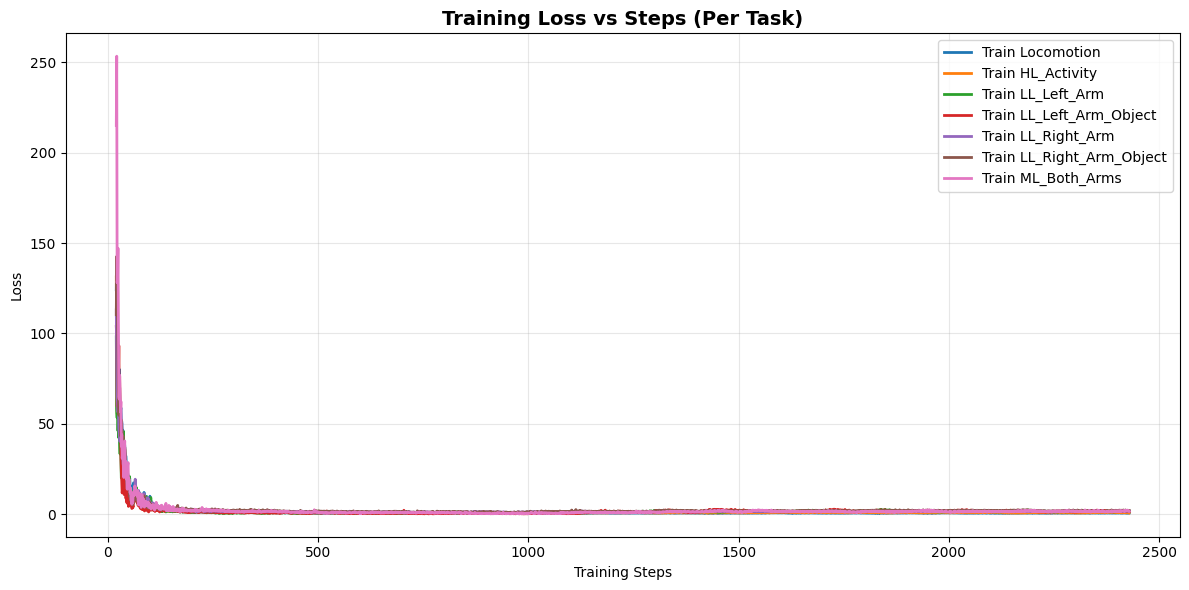

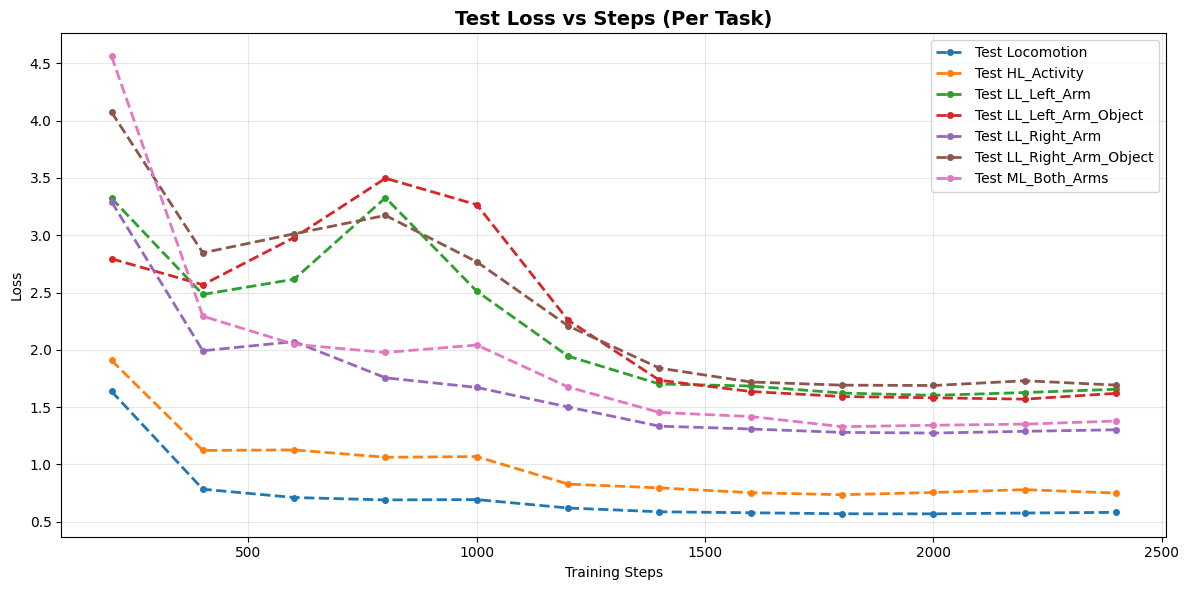

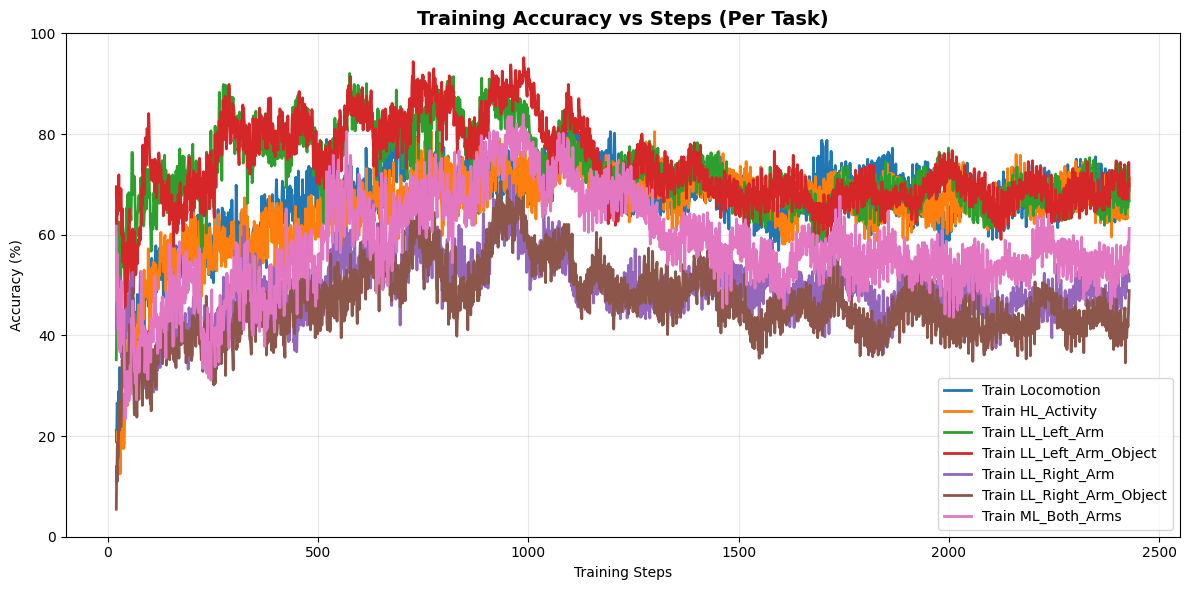

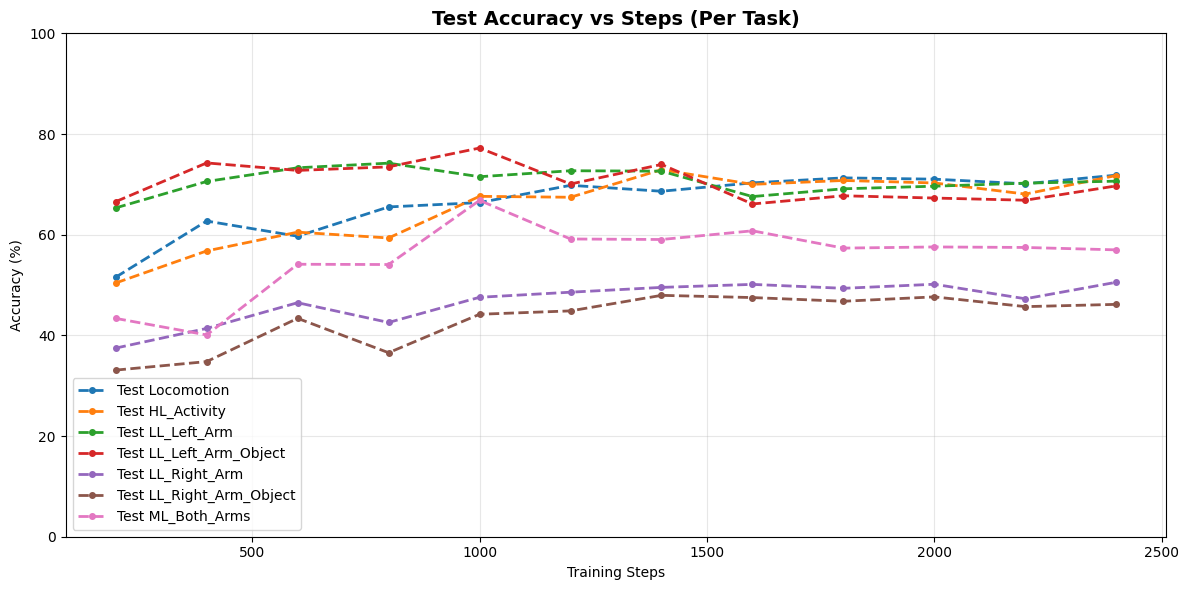

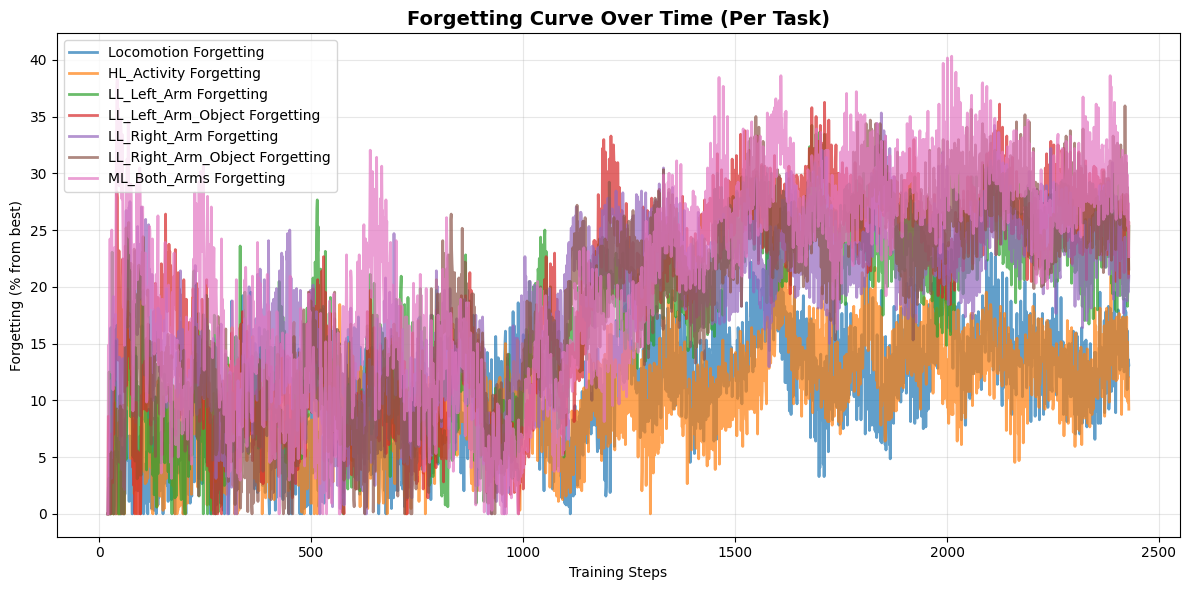

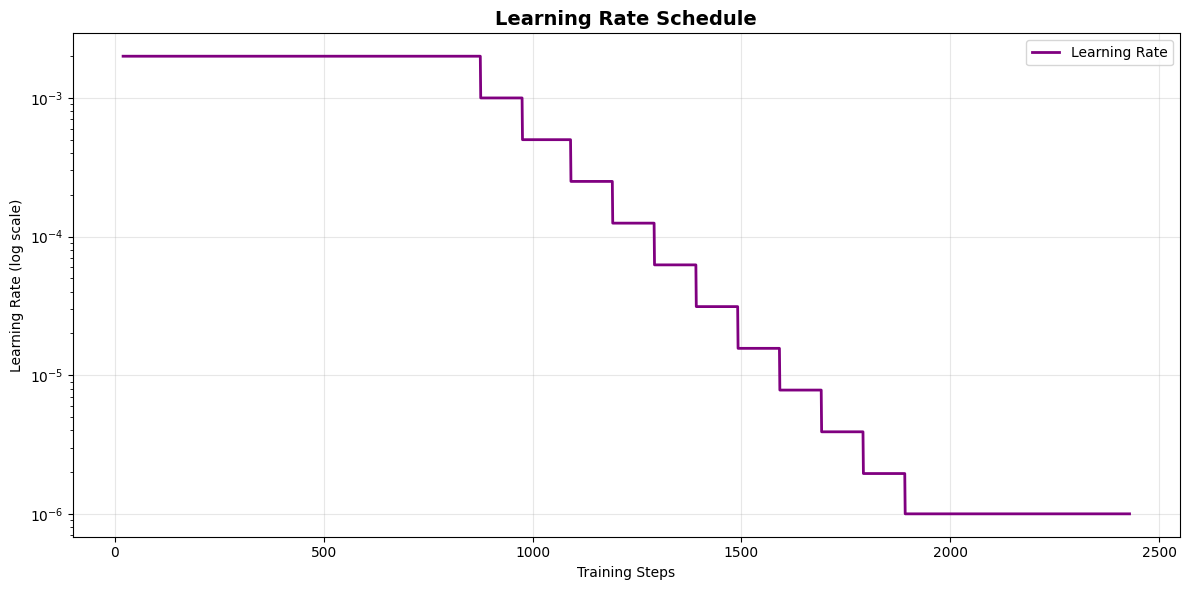

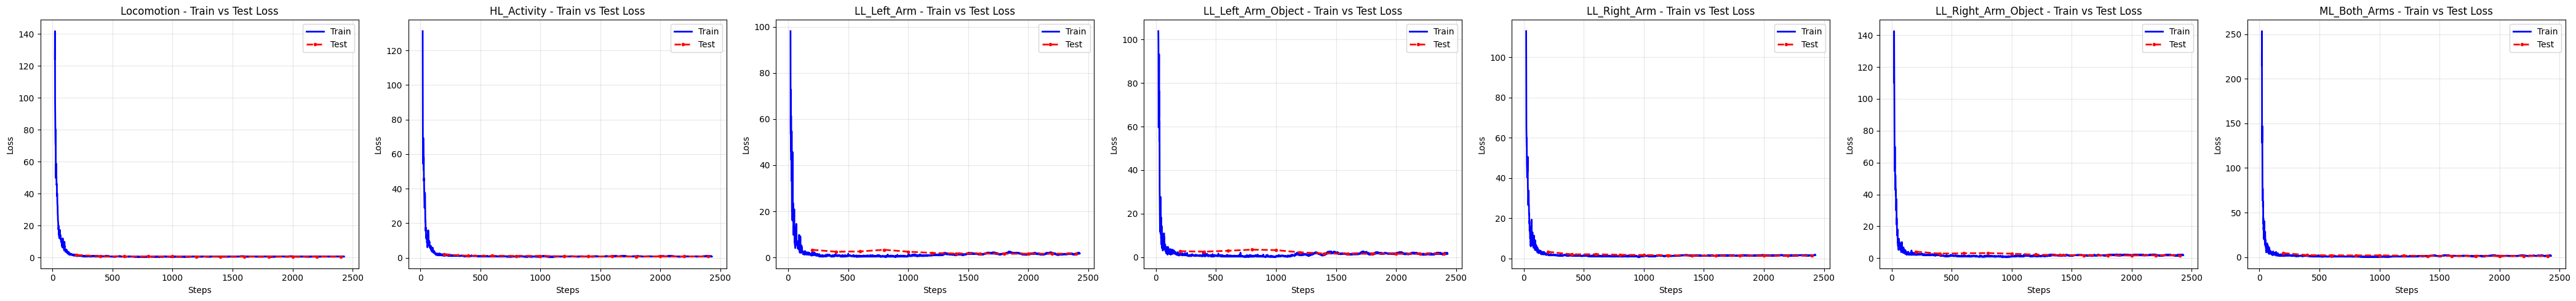

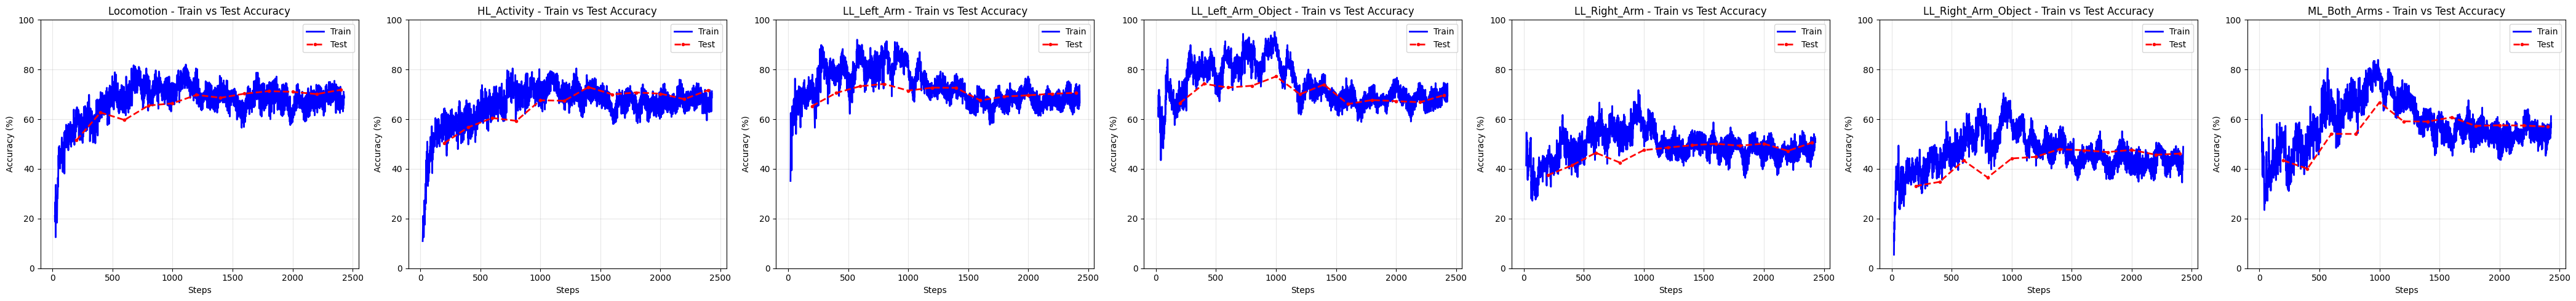

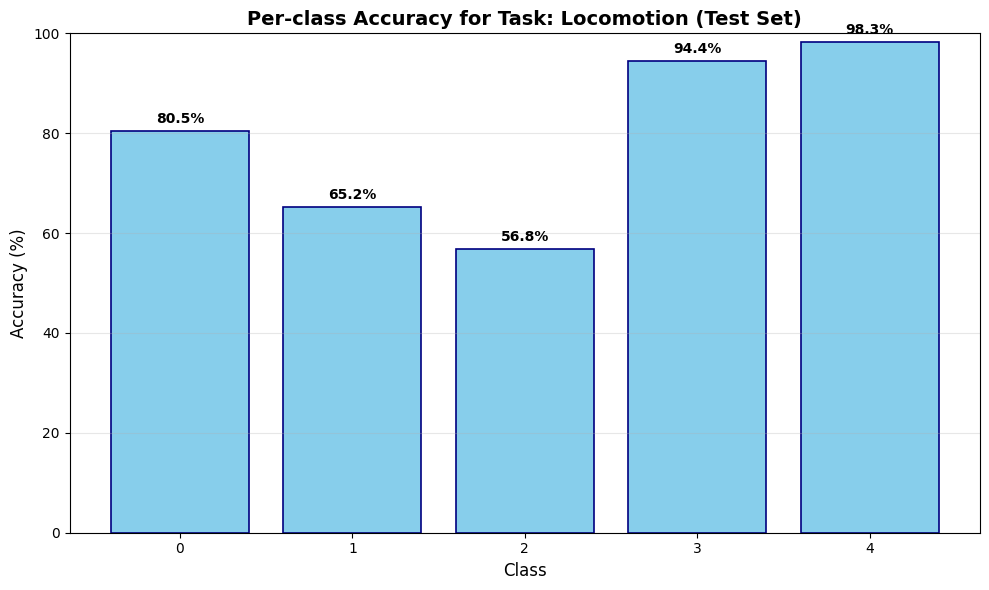


📊 Detailed Classification Report for Locomotion:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.76      0.80      0.78      1591
     Class 1       0.74      0.65      0.69      3308
     Class 2       0.57      0.57      0.57      2086
     Class 3       0.79      0.94      0.86      1213
     Class 4       0.84      0.98      0.90       302

    accuracy                           0.71      8500
   macro avg       0.74      0.79      0.76      8500
weighted avg       0.71      0.71      0.71      8500

--------------------------------------------------


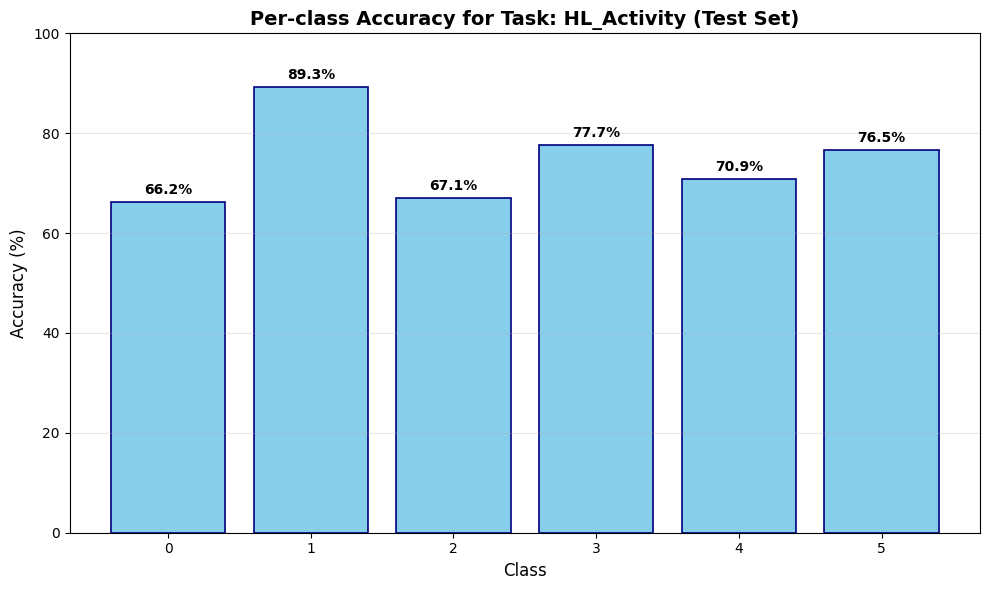


📊 Detailed Classification Report for HL_Activity:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.84      0.66      0.74      3169
     Class 1       0.57      0.89      0.70       476
     Class 2       0.49      0.67      0.57       850
     Class 3       0.85      0.78      0.81      1523
     Class 4       0.52      0.71      0.60       862
     Class 5       0.81      0.77      0.79      1620

    accuracy                           0.72      8500
   macro avg       0.68      0.75      0.70      8500
weighted avg       0.75      0.72      0.73      8500

--------------------------------------------------


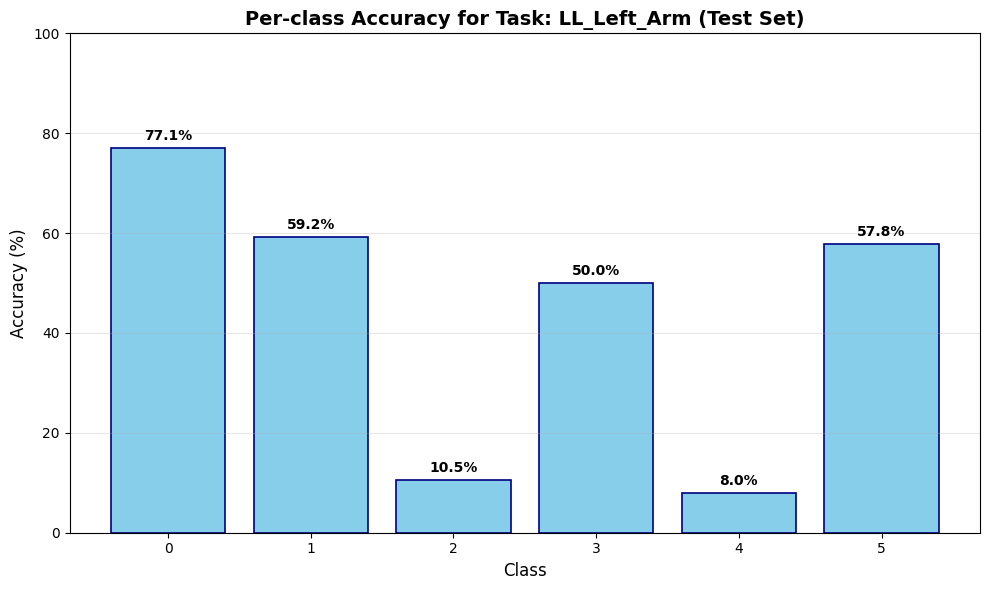


📊 Detailed Classification Report for LL_Left_Arm:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.97      0.77      0.86      7086
     Class 1       0.27      0.59      0.37       152
     Class 2       0.03      0.10      0.05       200
     Class 3       0.09      0.50      0.16        72
     Class 4       0.03      0.08      0.04       125
     Class 5       0.42      0.58      0.48       865

    accuracy                           0.72      8500
   macro avg       0.30      0.44      0.33      8500
weighted avg       0.86      0.72      0.78      8500

--------------------------------------------------


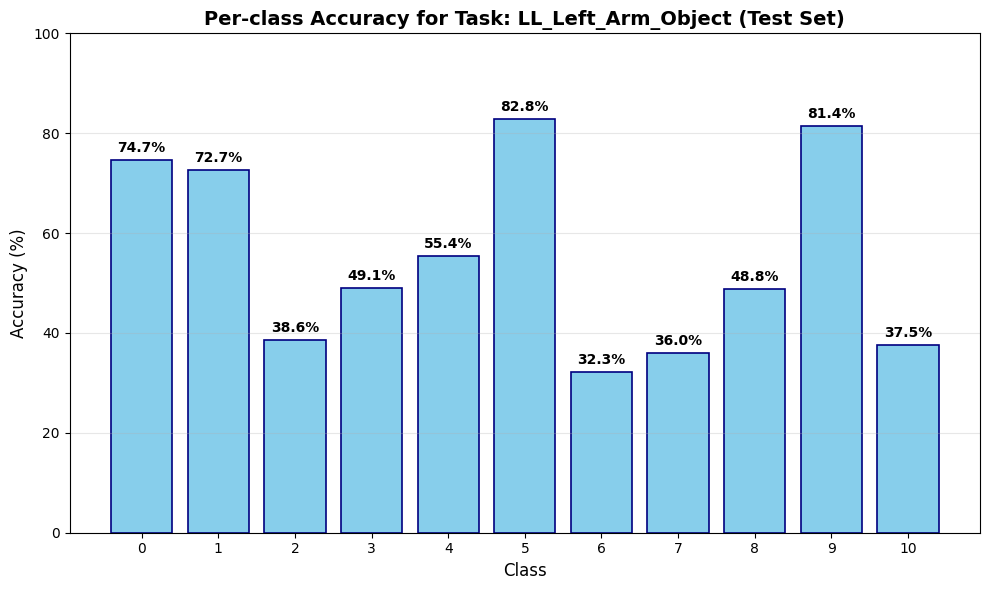


📊 Detailed Classification Report for LL_Left_Arm_Object:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.98      0.75      0.85      7252
     Class 1       0.27      0.73      0.39        55
     Class 2       0.29      0.39      0.33       189
     Class 3       0.27      0.49      0.35       279
     Class 4       0.32      0.55      0.40        74
     Class 5       0.12      0.83      0.21        29
     Class 6       0.04      0.32      0.07        31
     Class 7       0.14      0.36      0.20       100
     Class 8       0.20      0.49      0.28       127
     Class 9       0.44      0.81      0.57       236
    Class 10       0.09      0.38      0.15       128

    accuracy                           0.72      8500
   macro avg       0.29      0.55      0.35      8500
weighted avg       0.88      0.72      0.78      8500

--------------------------------------------------


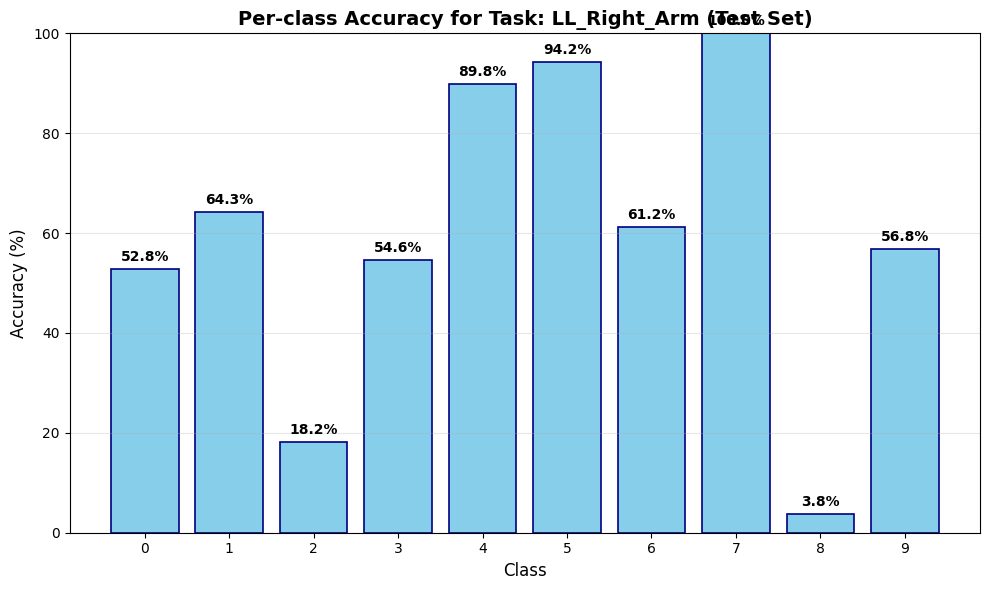


📊 Detailed Classification Report for LL_Right_Arm:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.94      0.53      0.68      5100
     Class 1       0.23      0.64      0.34       291
     Class 2       0.16      0.18      0.17       606
     Class 3       0.31      0.55      0.39       324
     Class 4       0.22      0.90      0.35       176
     Class 5       0.50      0.94      0.66       172
     Class 6       0.24      0.61      0.34       103
     Class 7       0.22      1.00      0.35        37
     Class 8       0.07      0.04      0.05       391
     Class 9       0.40      0.57      0.47      1300

    accuracy                           0.51      8500
   macro avg       0.33      0.60      0.38      8500
weighted avg       0.68      0.51      0.54      8500

--------------------------------------------------


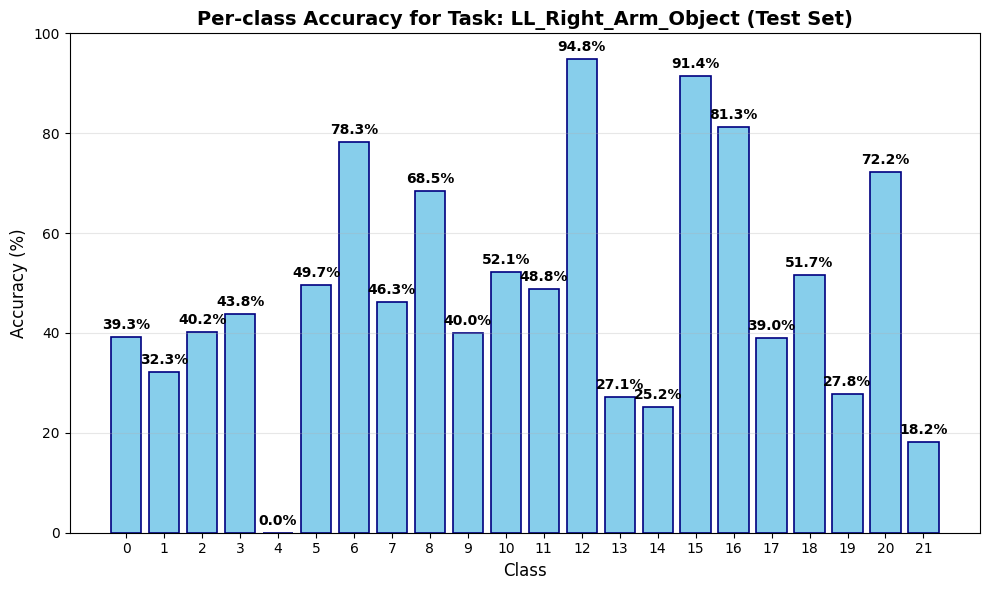


📊 Detailed Classification Report for LL_Right_Arm_Object:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.95      0.39      0.56      4976
     Class 1       0.27      0.32      0.29       127
     Class 2       0.43      0.40      0.42       174
     Class 3       0.36      0.44      0.39       356
     Class 4       0.00      0.00      0.00        25
     Class 5       0.29      0.50      0.37       159
     Class 6       0.10      0.78      0.18        69
     Class 7       0.24      0.46      0.31       147
     Class 8       0.28      0.68      0.40        92
     Class 9       0.17      0.40      0.24        50
    Class 10       0.35      0.52      0.42       117
    Class 11       0.50      0.49      0.49       129
    Class 12       0.60      0.95      0.73       192
    Class 13       0.28      0.27      0.28       225
    Class 14       0.19      0.25      0.22       115
    Class 15       0.37  

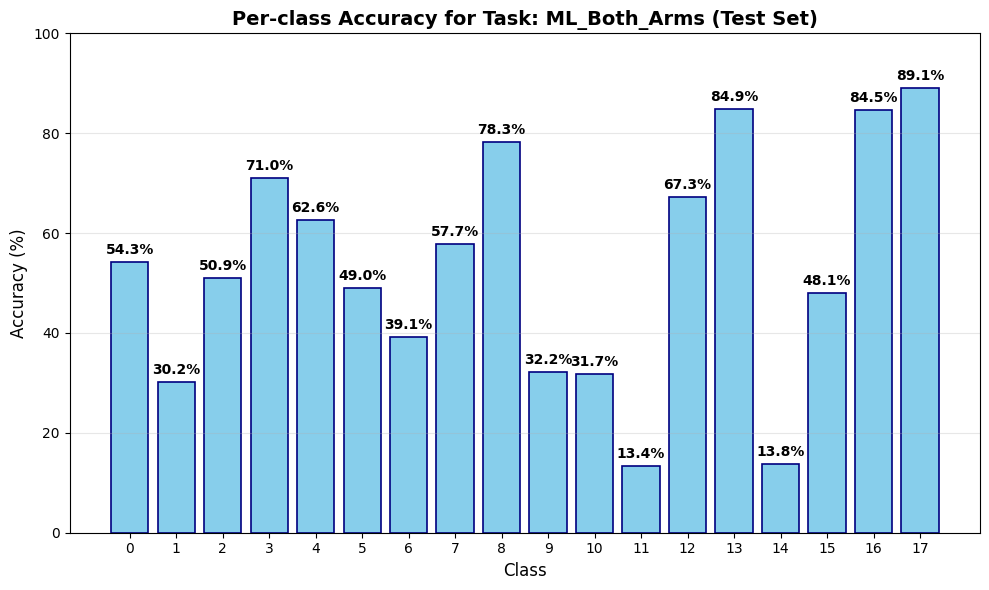


📊 Detailed Classification Report for ML_Both_Arms:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.96      0.54      0.69      6199
     Class 1       0.13      0.30      0.19        96
     Class 2       0.20      0.51      0.29        55
     Class 3       0.28      0.71      0.40        69
     Class 4       0.23      0.63      0.33       131
     Class 5       0.50      0.49      0.49       210
     Class 6       0.42      0.39      0.40        69
     Class 7       0.36      0.58      0.45       168
     Class 8       0.09      0.78      0.16        69
     Class 9       0.13      0.32      0.18        87
    Class 10       0.25      0.32      0.28        63
    Class 11       0.62      0.13      0.22        97
    Class 12       0.52      0.67      0.59       165
    Class 13       0.45      0.85      0.59       126
    Class 14       0.10      0.14      0.12        80
    Class 15       0.29      0.4

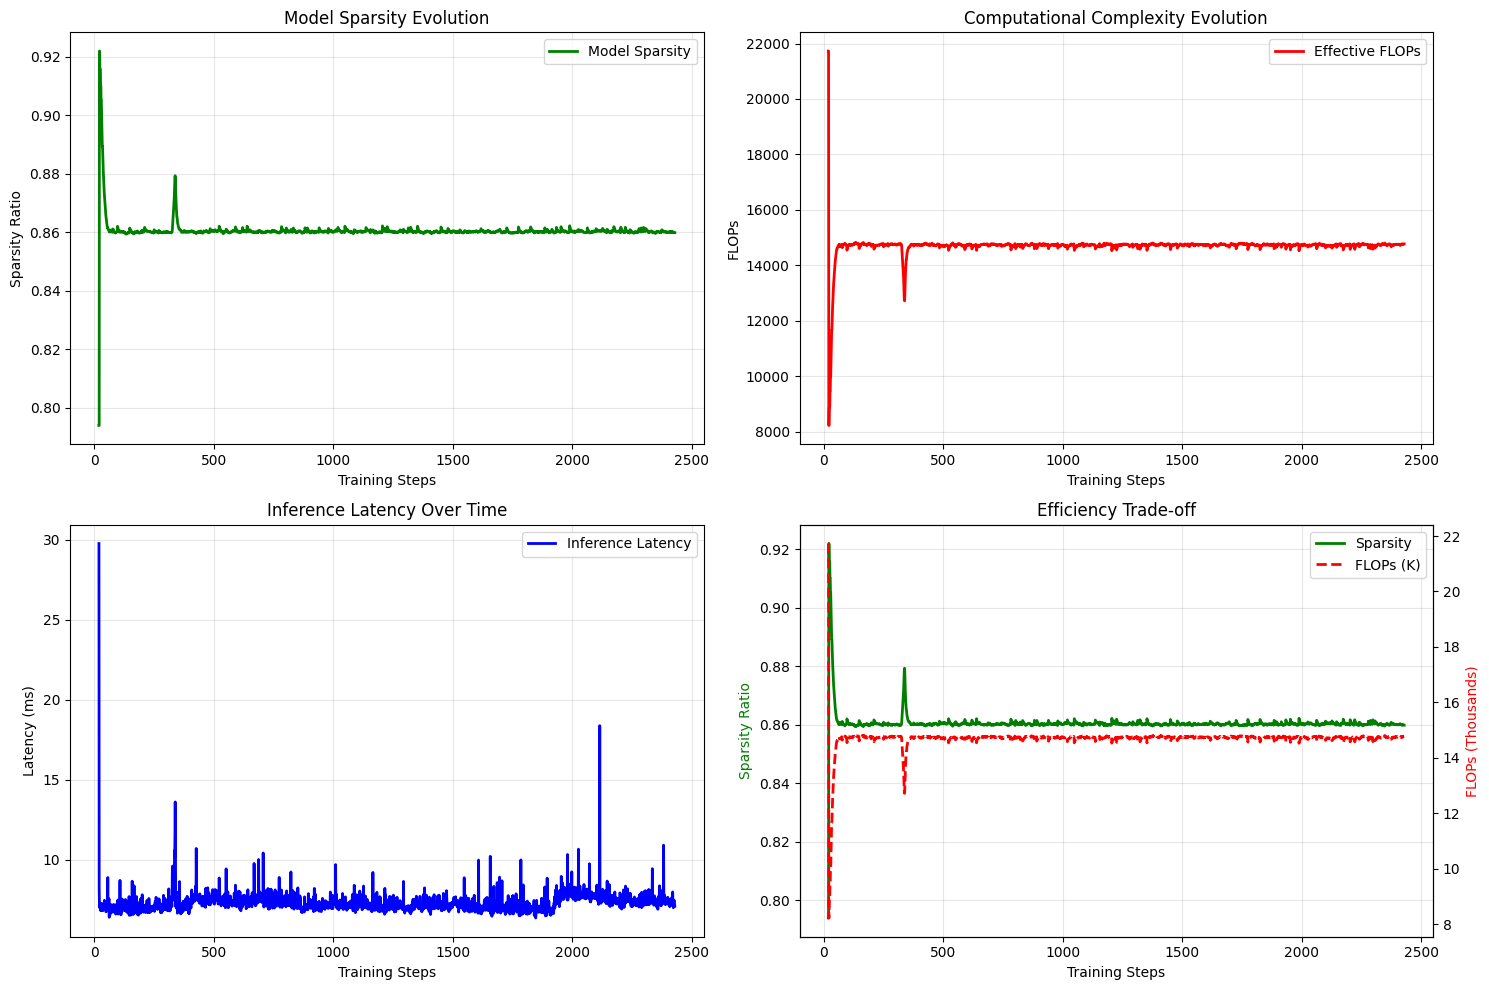

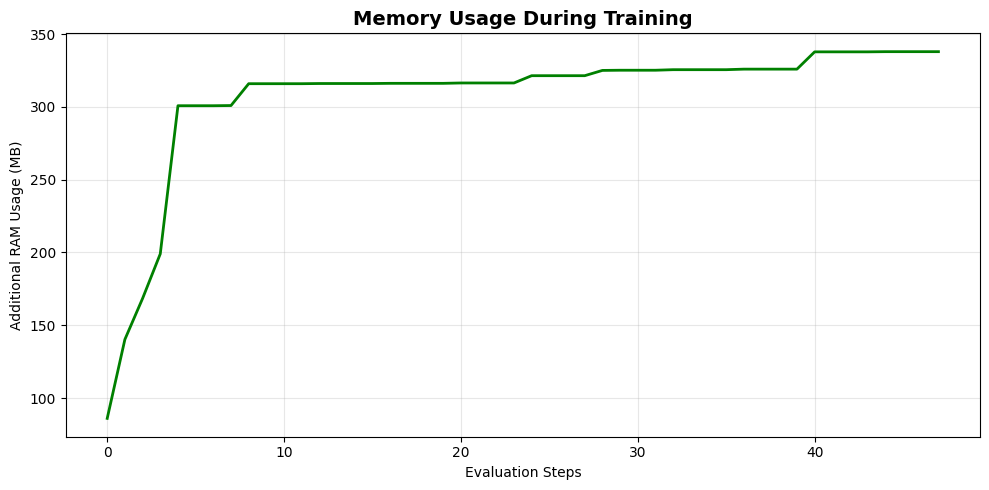

In [8]:
# First, convert your labels to mapped indices for training
train_labels_dict = {}
test_labels_dict = {}
for i, track in enumerate(label_tracks):
    train_labels_dict[track] = torch.from_numpy(train_y[:, i])
    test_labels_dict[track] = torch.from_numpy(test_y[:, i])

# Convert to mapped indices (0-based) for training
mapped_train_labels = model.map_labels_to_indices(train_labels_dict)
mapped_test_labels = model.map_labels_to_indices(test_labels_dict)

# Convert back to numpy for the training function
mapped_train_y = np.stack([mapped_train_labels[track].numpy() for track in label_tracks], axis=1)
mapped_test_y = np.stack([mapped_test_labels[track].numpy() for track in label_tracks], axis=1)

# Enhanced training with warmup scheduling
results = train_online_streaming_with_metrics(
    model,
    train_X_mod,
    mapped_train_y,  # 🔑 Use mapped labels instead of train_y
    test_X_mod=test_X_mod,
    test_y=mapped_test_y,  # 🔑 Use mapped labels instead of test_y
    label_tracks=label_tracks,
    total_steps=total_steps,
    lr=2e-3,  # This will be the target LR after warmup
    device="cuda" if torch.cuda.is_available() else "cpu",
    window_size=100,
    batch_size=32,
    stream_rate=5,
    print_every=50,
    eval_every=200,
    print_metrics_every=25,
    detailed_metrics=True,
    
    # 🌟 WARMUP SCHEDULING CONFIGURATION
    lr_scheduler_type='plateau',     # Use warmup instead of cosine
    lr_factor=0.5,                  # Reduction factor for plateau-based decay after warmup
    lr_patience=100,                # Steps to wait before reducing LR after warmup
    warmup_steps=100,               # 🔑 Number of warmup steps (gradual LR increase)
    patience=total_steps,
)

In [9]:
def unified_model_stats(model, count_dense_as_active=False):
    """
    Returns a normalized stats dict with keys:
      total_parameters, active_parameters, current_sparsity,
      estimated_flops, memory_full_mb, memory_active_mb,
      active_tasks, active_attention_heads
    Prefers the model's own get_model_stats(); falls back safely.
    """
    base = {}
    if hasattr(model, "get_model_stats"):
        try:
            base = model.get_model_stats() or {}
        except Exception:
            base = {}

    # 1) Pull from model's stats if available
    total_params = base.get("total_parameters", base.get("total_params"))
    active_params = base.get("active_parameters", base.get("active_params"))
    eff_sparsity = base.get("current_sparsity", base.get("effective_sparsity"))
    est_flops = base.get("estimated_flops")

    # 2) Fallbacks
    if total_params is None:
        total_params = sum(p.numel() for p in model.parameters())

    if active_params is None:
        # Sum masks for DynamicSparseLinear
        active_params = 0
        for m in model.modules():
            if m.__class__.__name__ == "DynamicSparseLinear":
                # mask has same shape as weight
                active_params += int(getattr(m, "mask").sum().item())
            elif count_dense_as_active:
                # Optionally treat non-sparse layers as fully active
                for p in m.parameters(recurse=False):
                    active_params += p.numel()

    if eff_sparsity is None:
        eff_sparsity = 1.0 - (active_params / max(1, total_params))

    if est_flops is None:
        # Reasonable proxy when not provided
        est_flops = active_params

    # 3) Memory estimates using actual dtype size
    try:
        elem_size = next(model.parameters()).element_size()
    except StopIteration:
        elem_size = 4  # default to float32
    memory_full_mb = total_params * elem_size / (1024**2)
    memory_active_mb = active_params * elem_size / (1024**2)

    # 4) Extras
    active_tasks = base.get("active_tasks", getattr(getattr(model, "classifier", None), "active_tasks", None))
    active_attention_heads = base.get("active_attention_heads", getattr(getattr(model, "fusion", None), "active_heads", None))

    return {
        "total_parameters": int(total_params),
        "active_parameters": int(active_params),
        "current_sparsity": float(eff_sparsity),
        "estimated_flops": float(est_flops),
        "memory_full_mb": float(memory_full_mb),
        "memory_active_mb": float(memory_active_mb),
        "active_tasks": active_tasks,
        "active_attention_heads": active_attention_heads,
    }


In [10]:
stats = unified_model_stats(model)  # default: counts only masked params as active

print(f"Total parameters: {stats['total_parameters']}")
print(f"Active parameters: {stats['active_parameters']}")
print(f"Sparsity: {stats['current_sparsity']:.4f}")
print(f"Estimated FLOPs: {stats['estimated_flops']}")
print(f"Memory (full): {stats['memory_full_mb']:.2f} MB")
print(f"Memory (active): {stats['memory_active_mb']:.2f} MB")
print(f"Active tasks: {stats['active_tasks']}")
print(f"Active attention heads: {stats['active_attention_heads']}")


Total parameters: 105454
Active parameters: 14777
Sparsity: 0.8599
Estimated FLOPs: 14777.0
Memory (full): 0.40 MB
Memory (active): 0.06 MB
Active tasks: 7
Active attention heads: 4


In [11]:
import torch
import json

def save_adaptive_model(model: AdaptiveLightSpaN, 
                        filepath_prefix: str = "adaptive_lightspan_model"):
    """
    Saves the model state_dict, sparsity masks, and stats to disk.
    """
    # 1️⃣ Save model state_dict
    torch.save(model.state_dict(), f"{filepath_prefix}_state.pth")
    
    # 2️⃣ Save model stats (total params, active params, sparsity, etc.)
    stats = model.get_model_stats()
    with open(f"{filepath_prefix}_stats.json", "w") as f:
        json.dump(stats, f, indent=4)
    
    print(f"✅ Model saved successfully:\n- Weights: {filepath_prefix}_state.pth\n- Stats: {filepath_prefix}_stats.json")


In [12]:
save_adaptive_model(model)

✅ Model saved successfully:
- Weights: adaptive_lightspan_model_state.pth
- Stats: adaptive_lightspan_model_stats.json
